Una vez obtenido el dataset completo y limpio, estamos en condiciones de proceder a la implementación de técnicas de detección de idioma. Realicemos un breve análisis exploratorio.

In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pickle
import seaborn as sns 
import math
import os
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

np.random.seed(42)
tf.random.set_seed(42)


In [3]:
df_texto=pd.read_csv('dataset_oraciones_limpio.csv')
df_texto.head(10)

,Texto,Idioma,Longitud
0,reanudación del período de sesiones,es,5
1,el parlamento de pie guarda un minuto de silencio,es,9
2,todo ello de conformidad con los principios qu...,es,11
3,orden de los trabajos,es,4
4,aplausos del grupo pse,es,4
5,aplausos del grupo ppede,es,4
6,¿algún colega tomará la palabra en nombre del ...,es,13
7,gracias señor poettering,es,3
8,escuchemos ahora al sr wurtz que hablará en co...,es,12
9,el parlamento rechaza la propuesta por votos ...,es,14


In [4]:
def contar_letras(dataset):
    conteo = Counter()
    total = 0
    for oraciones in dataset:
        letras = [c for c in oraciones if c.isalpha()]
        conteo.update(letras)
        total += len(letras)
    return {letra: freq / total for letra, freq in sorted(conteo.items(),  key=lambda x: x[1], reverse=True)}

In [5]:
frecuencias_por_idioma ={}
for idioma in df_texto["Idioma"].unique():
    textos_idioma = df_texto[df_texto["Idioma"] == idioma]["Texto"]
    frecuencias_por_idioma[idioma] = contar_letras(textos_idioma)
resultados=frecuencias_por_idioma.items()


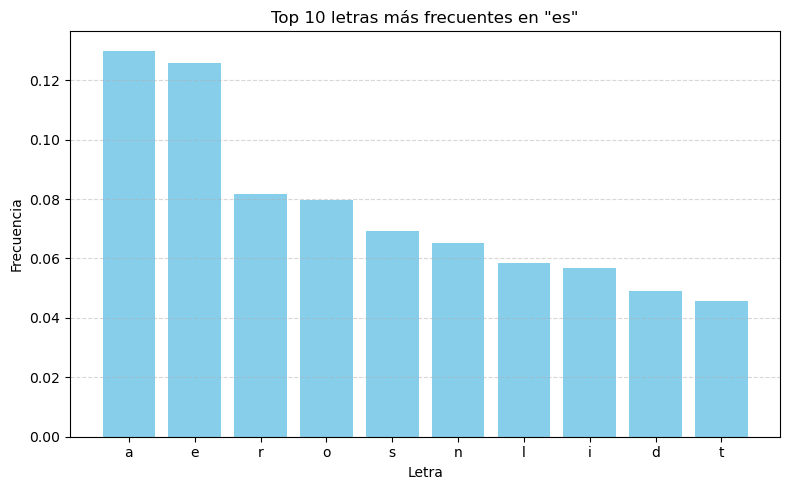

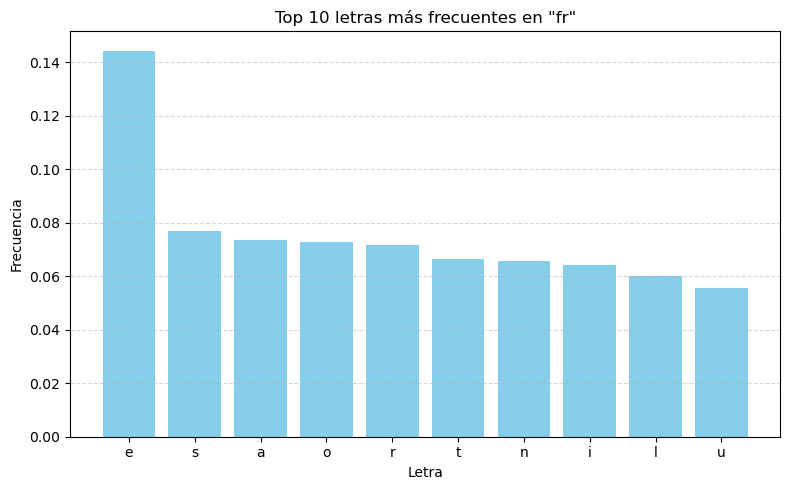

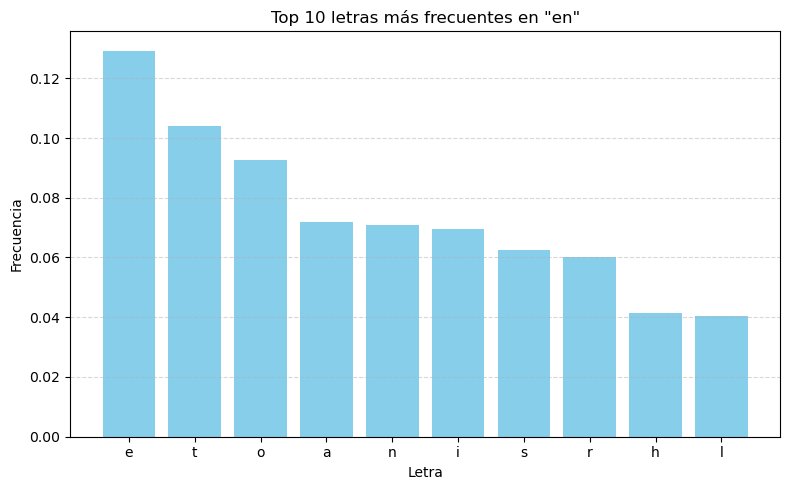

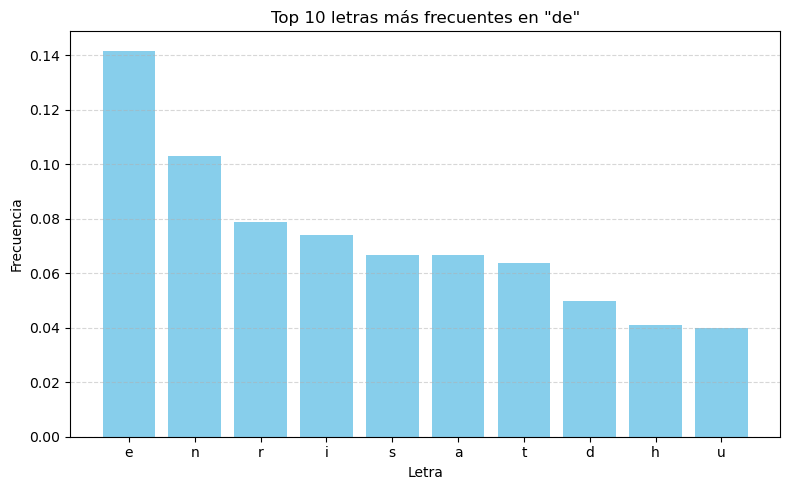

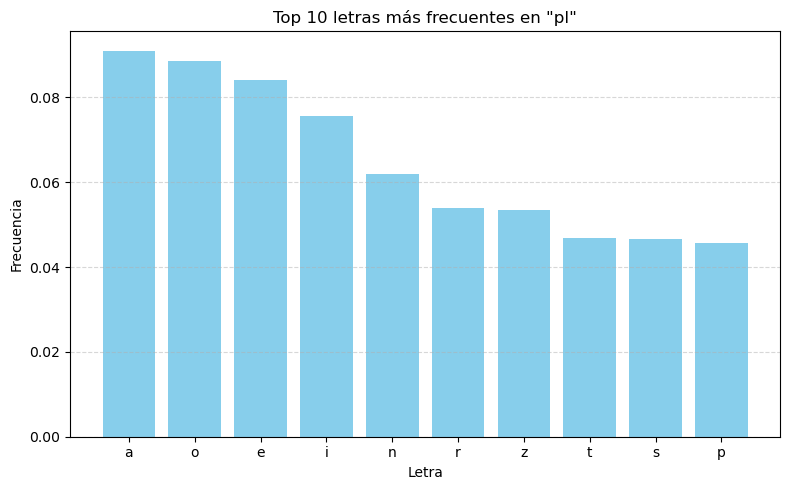

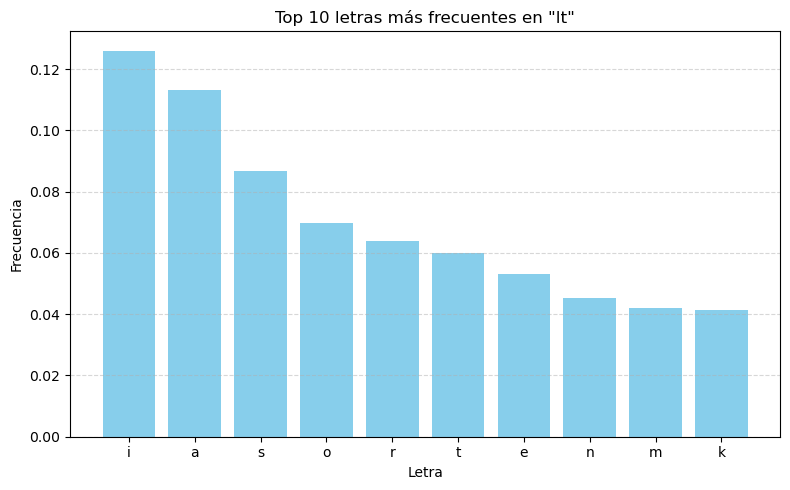

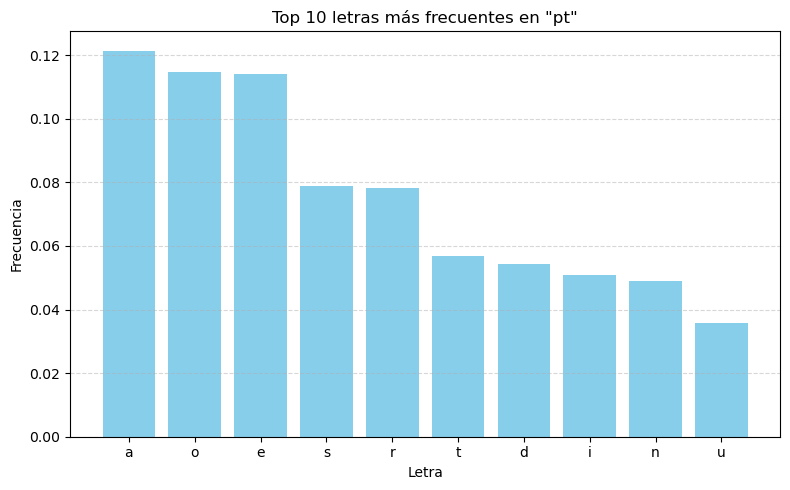

In [6]:

# Dibujar gráficos
for idioma, diccionario in resultados:
    top_10 = list(diccionario.items())[:10]
    letras = [letra for letra, _ in top_10]
    frecuencias = [freq for _, freq in top_10]
    plt.figure(figsize=(8, 5))
    plt.bar(letras, frecuencias, color='skyblue')
    plt.title(f'Top 10 letras más frecuentes en "{idioma}"')
    plt.xlabel('Letra')
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


Observamos que existen ciertas diferencias entre idiomas. En español las letras más comunes son las vocales `a` y `e`, mientras que en otros idiomas como el inglés, el frnacés y el alemán la letra `a` aparece con menos frecuencia. Destacar que en el polaco y lituano , la `z` y la `k ` son una de las letras más repetidas de cada idioma respectivamente. 

Sería interesante estudiar las probabilidades condicionadas para algunas letras en los distintos idiomas, ya que es de esperar que haya combinaciones de letras particulares por idiomas. Por ejemplo, en inglés la probabilidad de que dada una `t` le siga una `h` es mucho más alta que si buscamos esta combinación de letras en español.  

In [8]:
def obtener_frecuencia_condicionada_letras(dataset):
    contador_bigramas = defaultdict(Counter)
    
    for frase in dataset:
        caracteres = [c for c in frase if c.isalpha() or c == ' ']
        for i in range(len(caracteres) - 1):
            letra_actual = caracteres[i]
            letra_siguiente = caracteres[i + 1]
            contador_bigramas[letra_actual][letra_siguiente] += 1
    
    # Convertimos el defaultdict a un diccionario normal
    frecuencia_condicionada = {k: dict(v) for k, v in contador_bigramas.items()}

    return frecuencia_condicionada

def convertir_a_probabilidades(frecuencia_condicionada):
    probabilidad_condicionada = {}
    
    for letra_inicial, siguientes in frecuencia_condicionada.items():
        total = sum(siguientes.values())
        probabilidad_condicionada[letra_inicial] = {
            letra_siguiente: frecuencia / total
            for letra_siguiente, frecuencia in siguientes.items()
        }
    
    return probabilidad_condicionada

def visualizar_matriz_transicion(probabilidad_condicionada,idioma,letras_comunes):
    
    # Creamos una matriz para el mapa de calor
    n=len(letras_comunes)
    matriz = np.zeros((n,n))
    
    # Llenamos la matriz con las probabilidades
    for i, letra_inicial in enumerate(letras_comunes):
        if letra_inicial in probabilidad_condicionada:
            for j, letra_siguiente in enumerate(letras_comunes):
                if letra_siguiente in probabilidad_condicionada[letra_inicial]:
                    matriz[i, j] = probabilidad_condicionada[letra_inicial][letra_siguiente]
    
    # Creamos el mapa de calor
    plt.figure(figsize=(18, 10))
    sns.heatmap(matriz, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=letras_comunes, yticklabels=letras_comunes)
    plt.title(f'Matriz de Transición entre Letras de {idioma}')
    plt.xlabel('Letra Siguiente')
    plt.ylabel('Letra Actual')
    plt.tight_layout()
    plt.show()


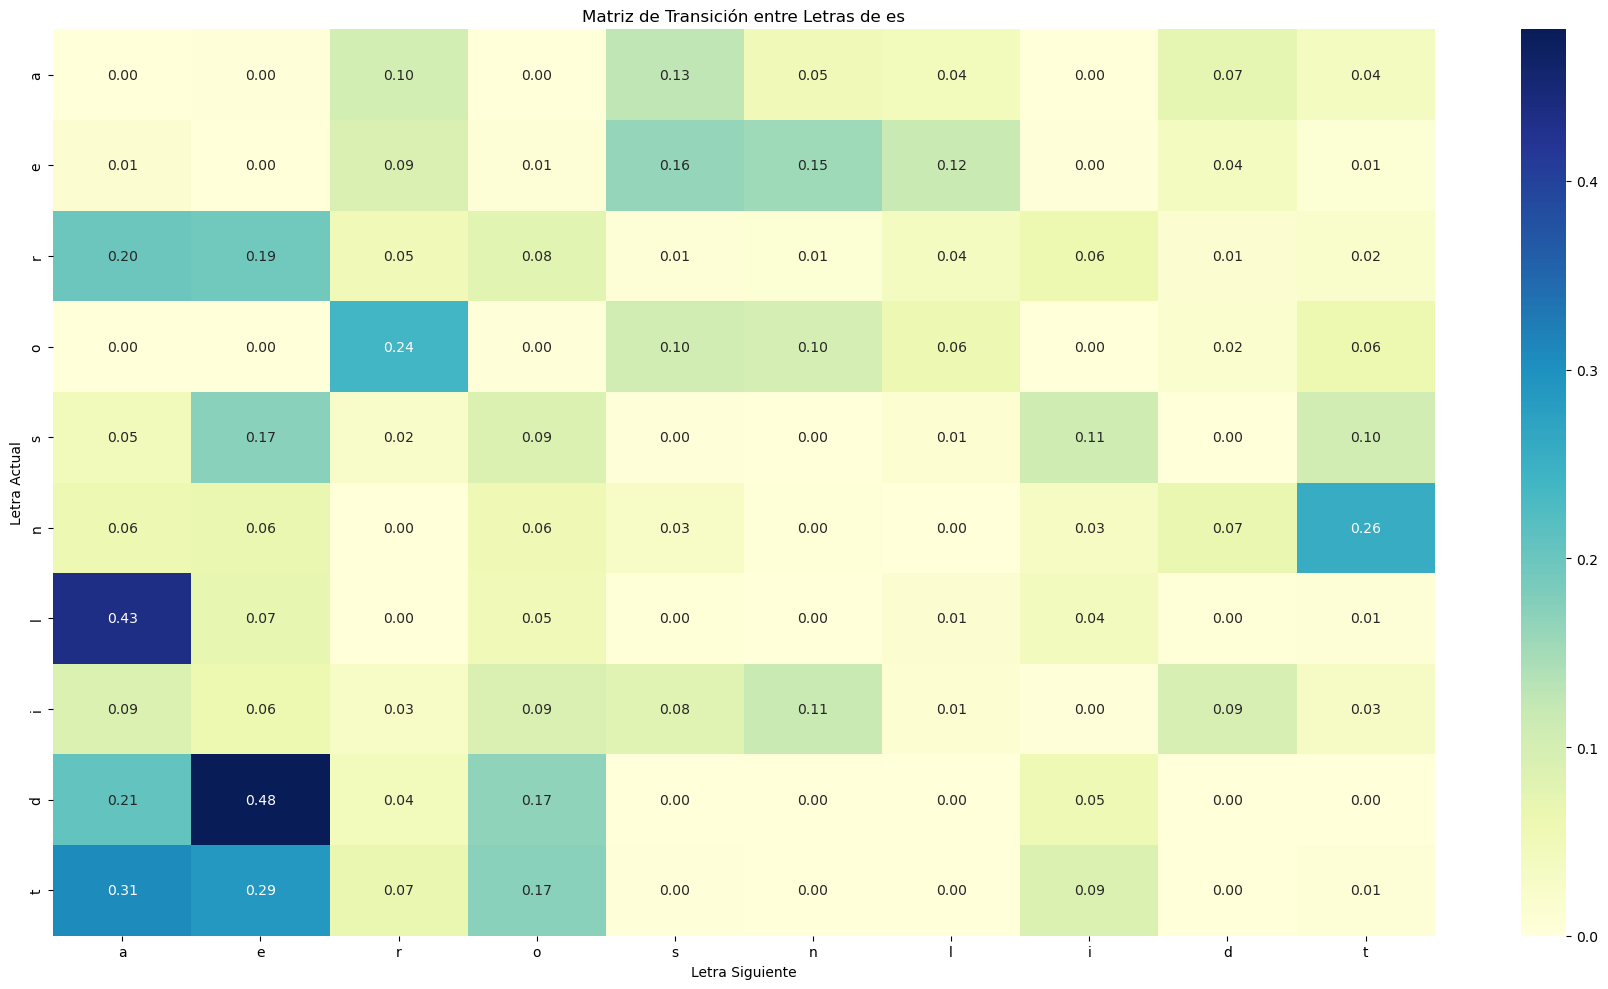

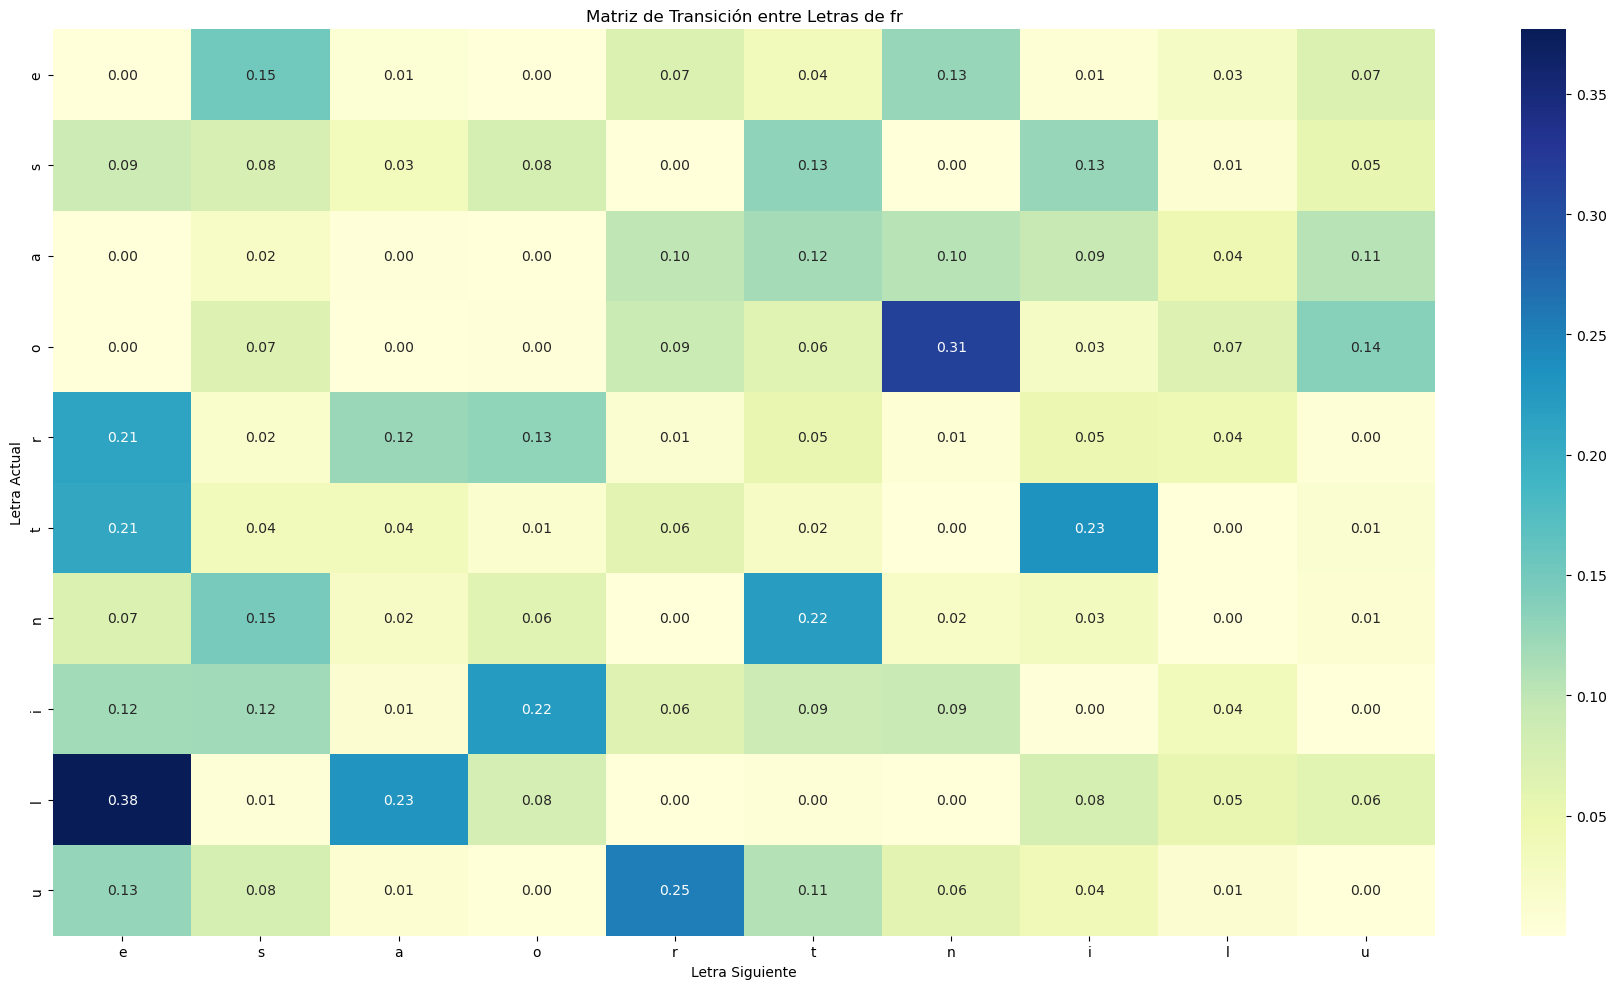

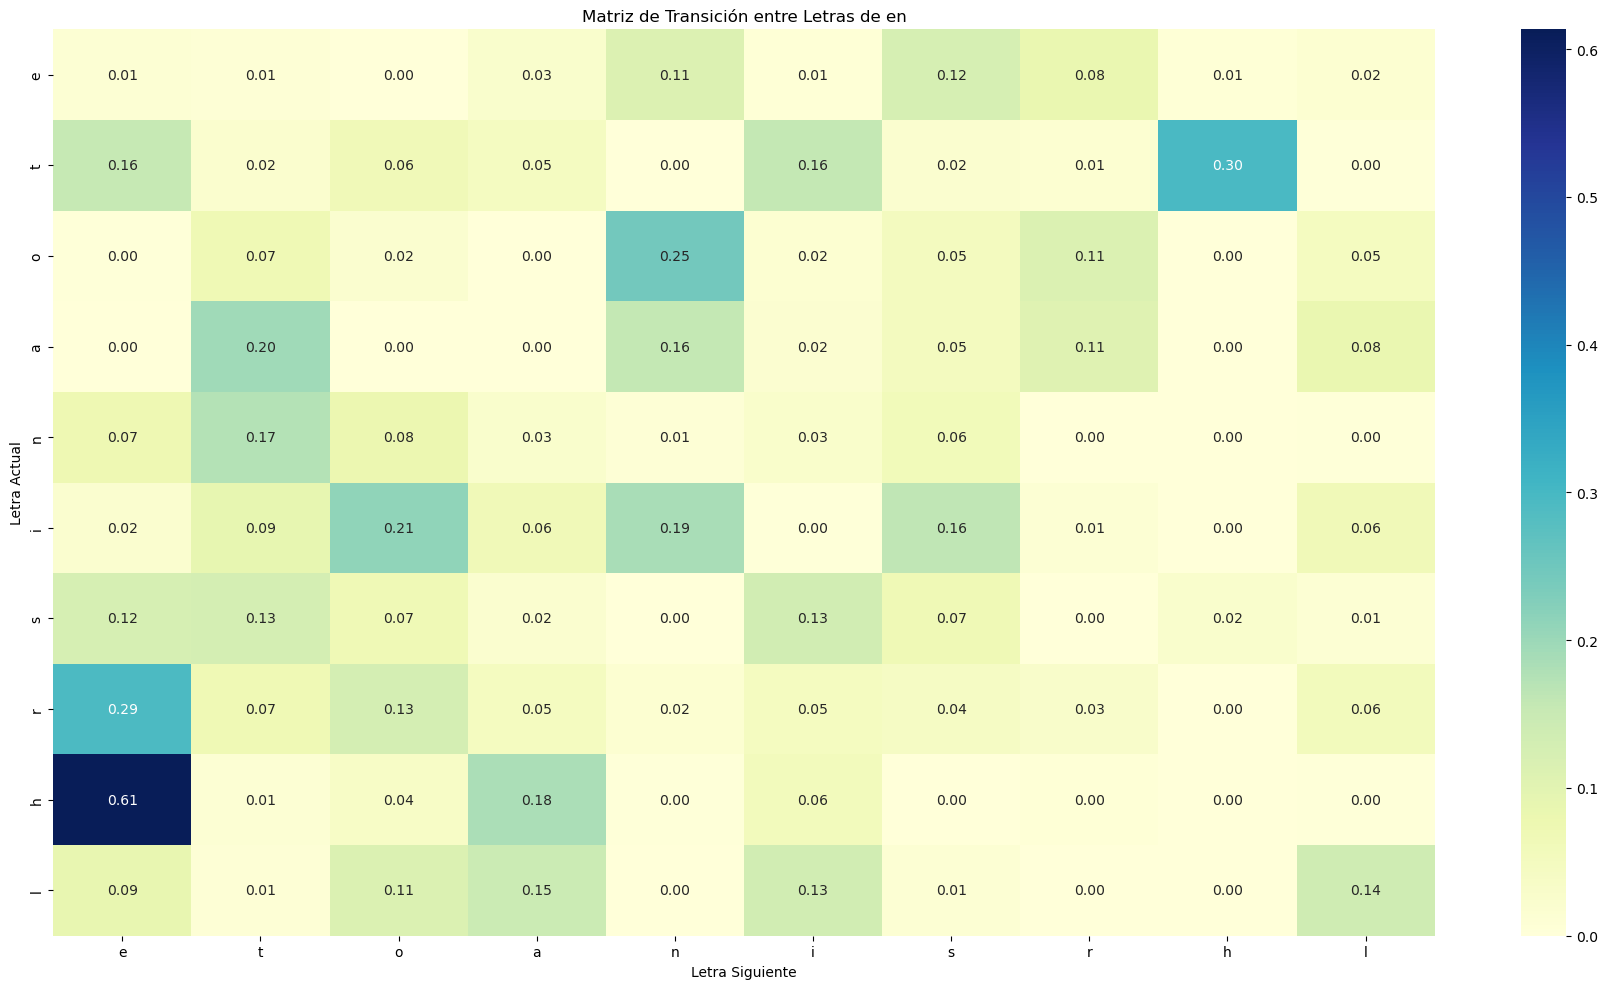

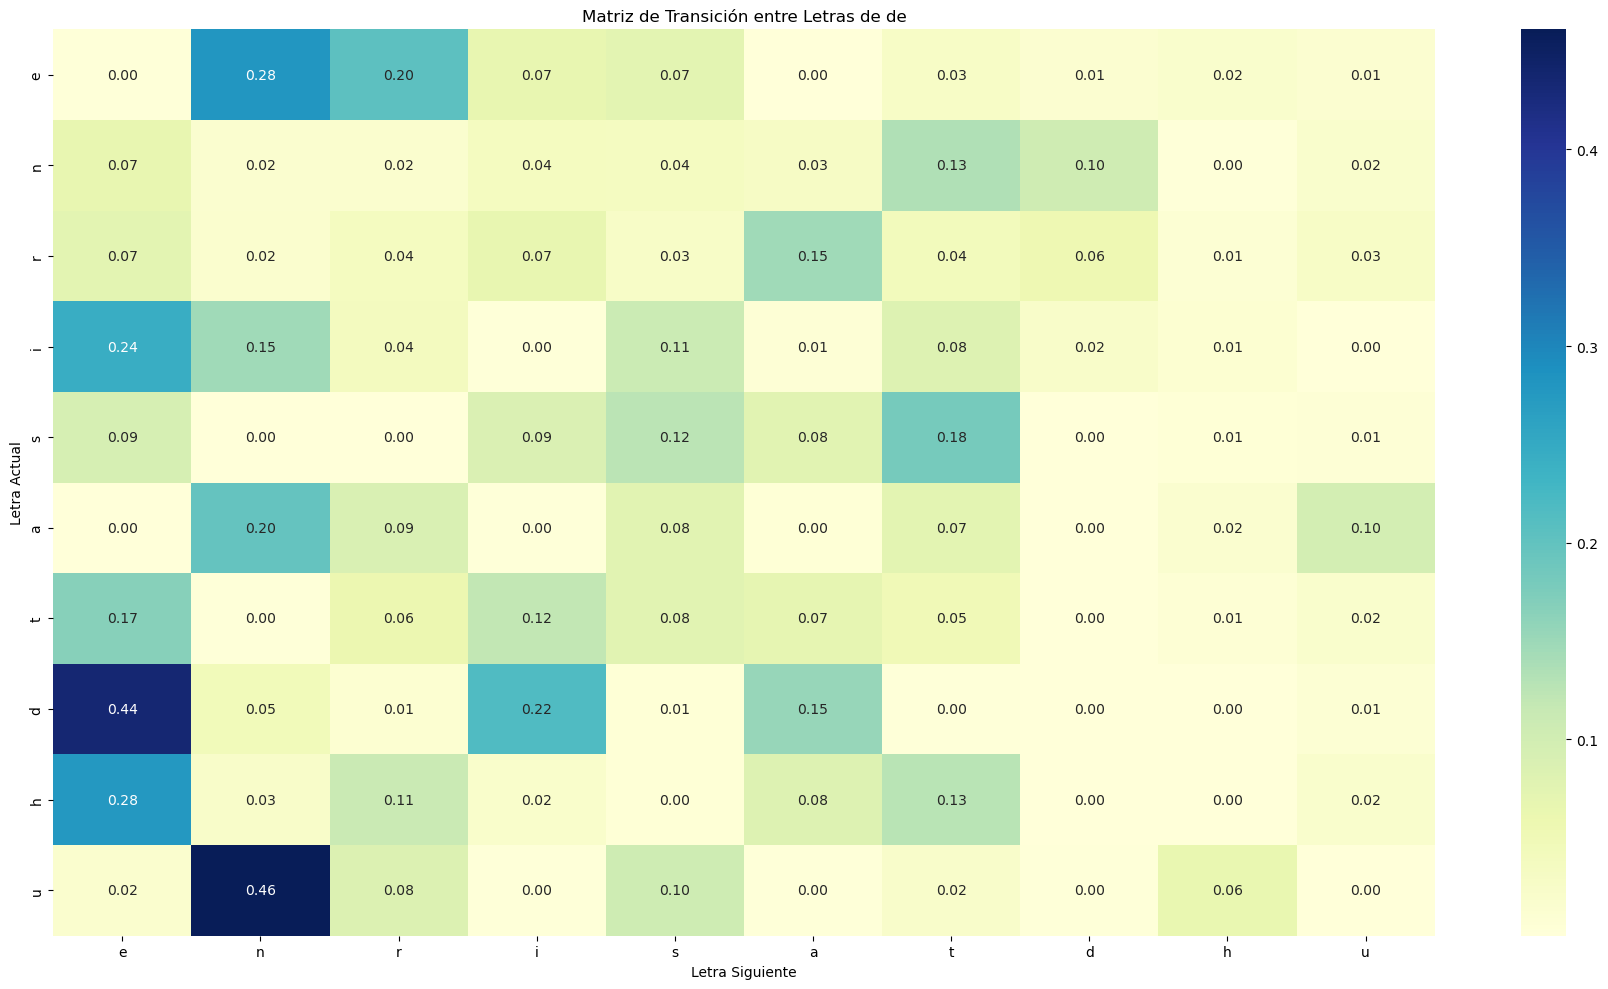

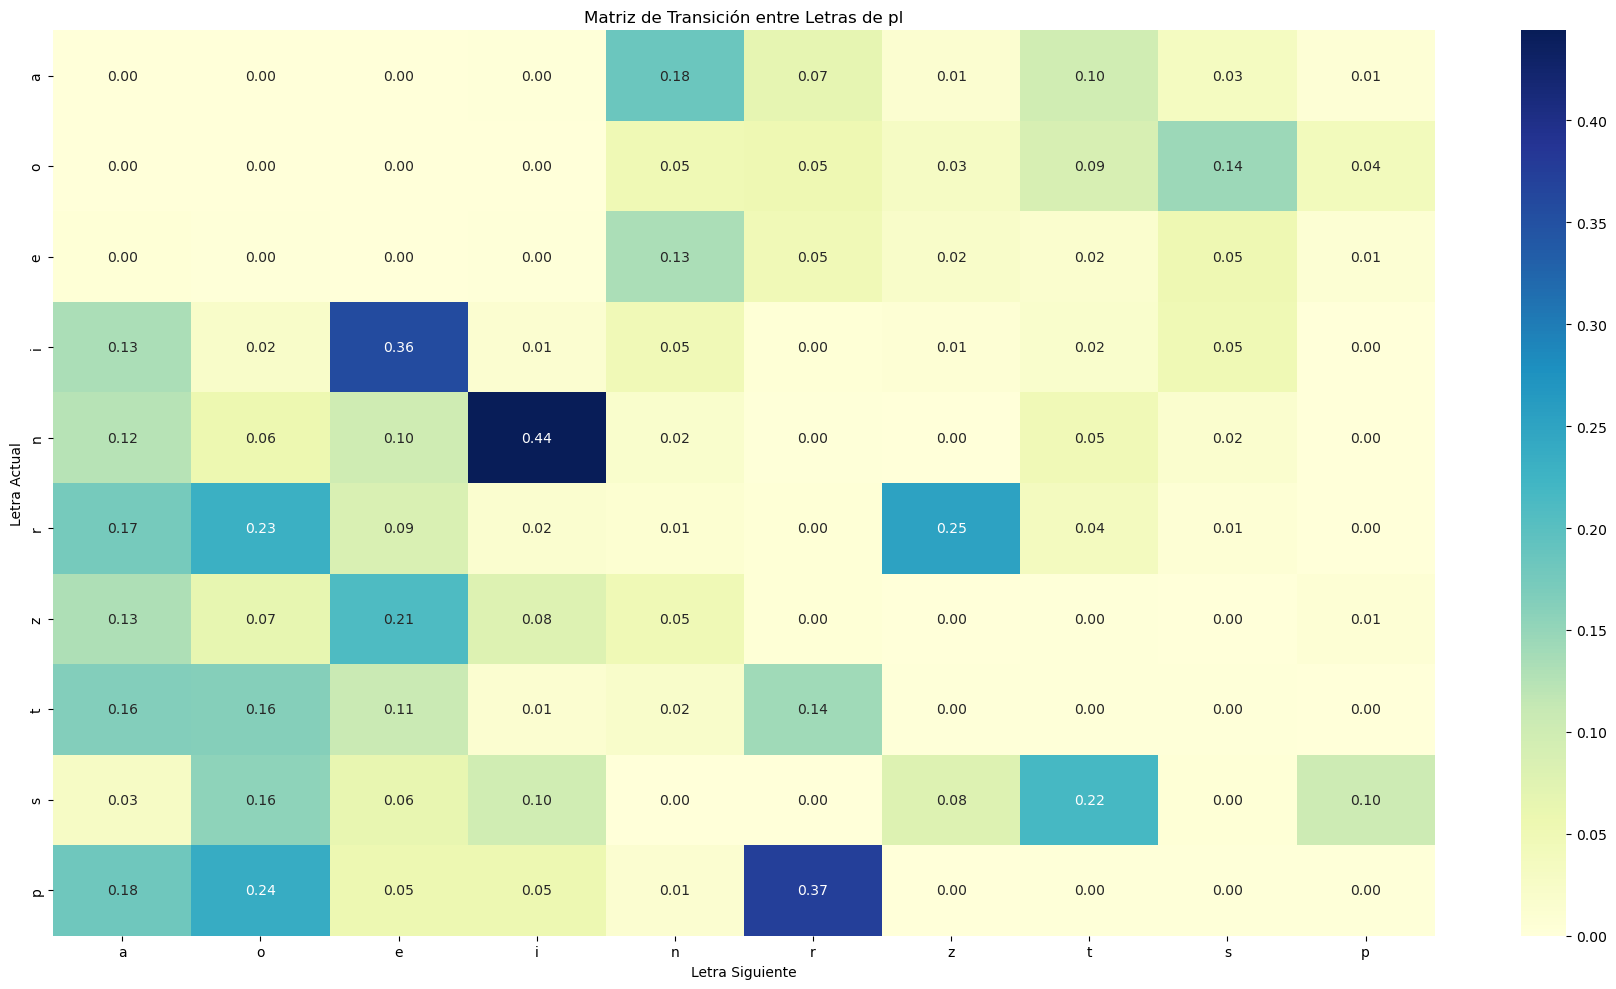

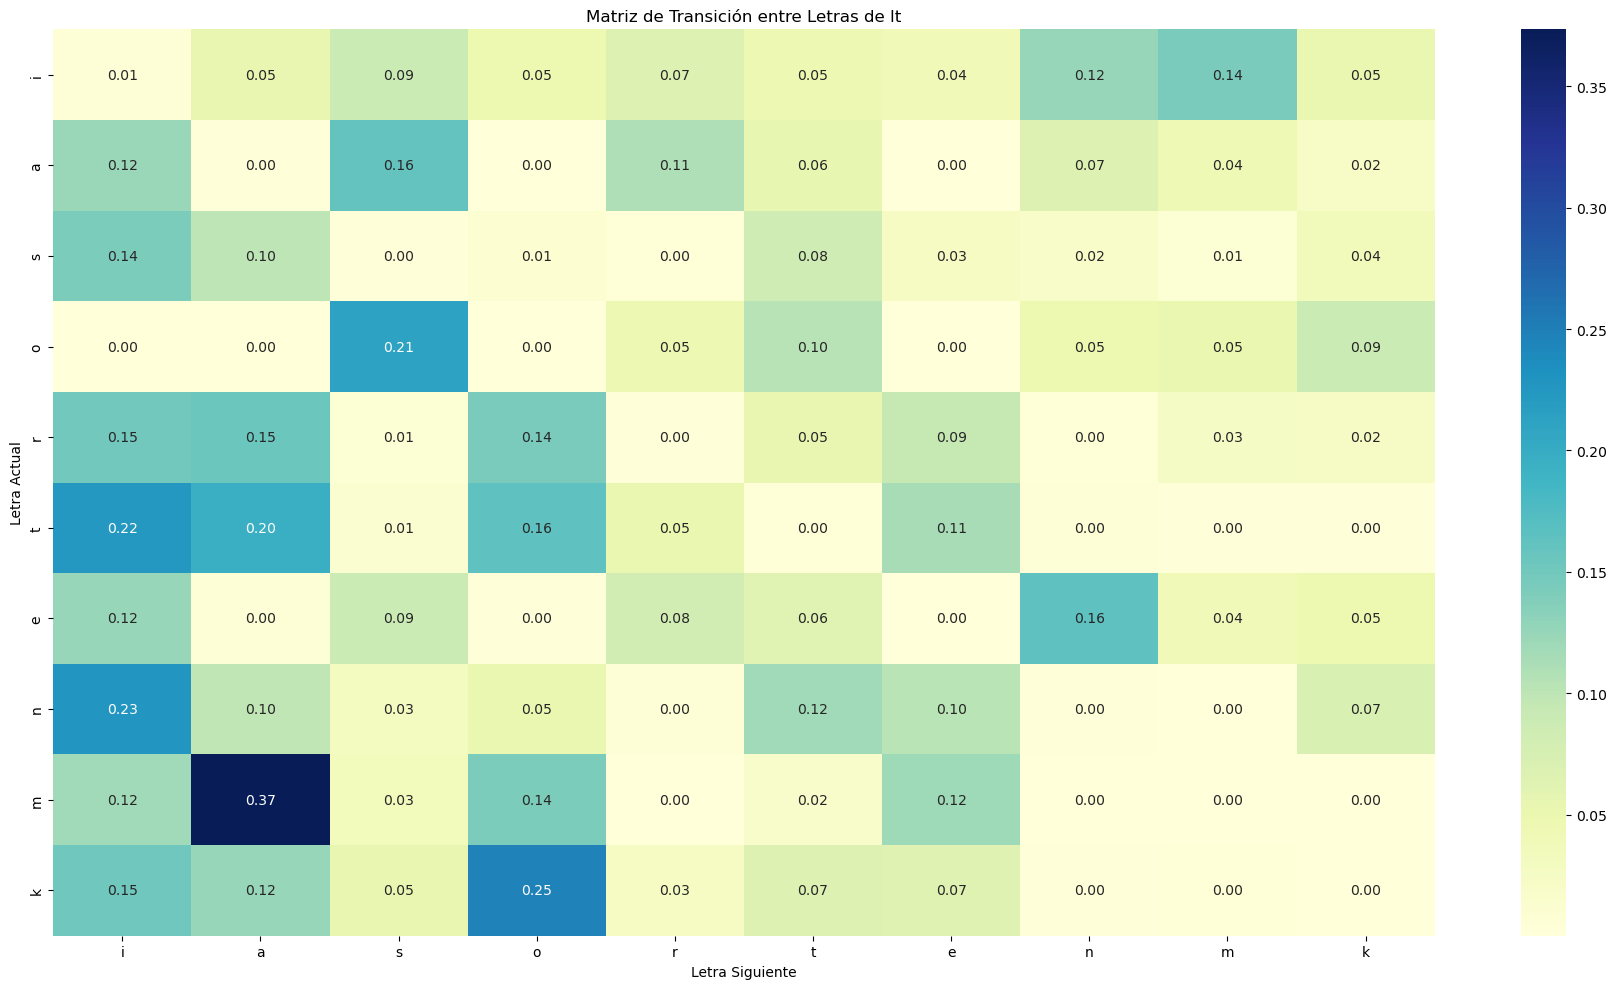

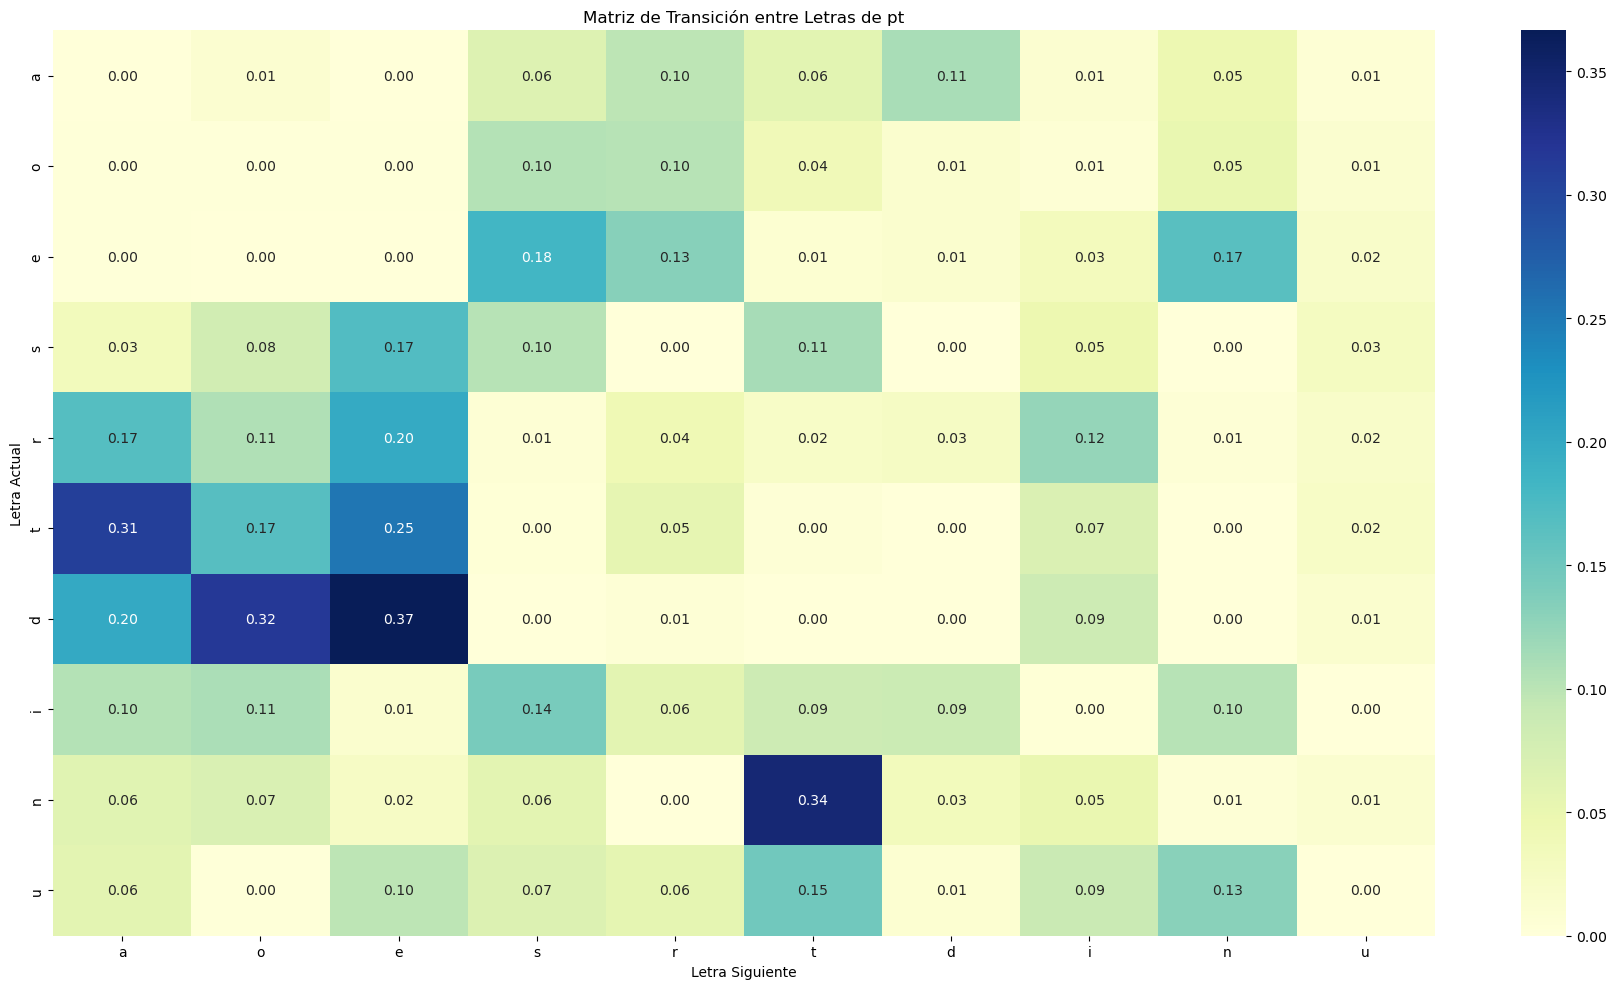

In [9]:
for idioma in df_texto["Idioma"].unique():
    text=df_texto[df_texto["Idioma"]==idioma]["Texto"]
    frecuencia_letras = contar_letras(text)
    letras_comunes = list(frecuencia_letras.keys())[:10]
    frecuencia_condicionada=obtener_frecuencia_condicionada_letras(text)
    probabilidad_condicionada = convertir_a_probabilidades(frecuencia_condicionada)
    visualizar_matriz_transicion(probabilidad_condicionada,idioma,letras_comunes)

Por último, veamos qué palabras son las más repetidas en cada idioma.

In [11]:
def top_palabras(df,n=10):
    word_freq={}
    for idioma in df["Idioma"].unique():
        df_idioma=df[df["Idioma"]==idioma]["Texto"]
        all_text=''.join(df_idioma)
        palabras=all_text.split()
        word_counts=Counter(palabras)
        top_n=word_counts.most_common(n)
        word_freq[idioma]=top_n
    return word_freq

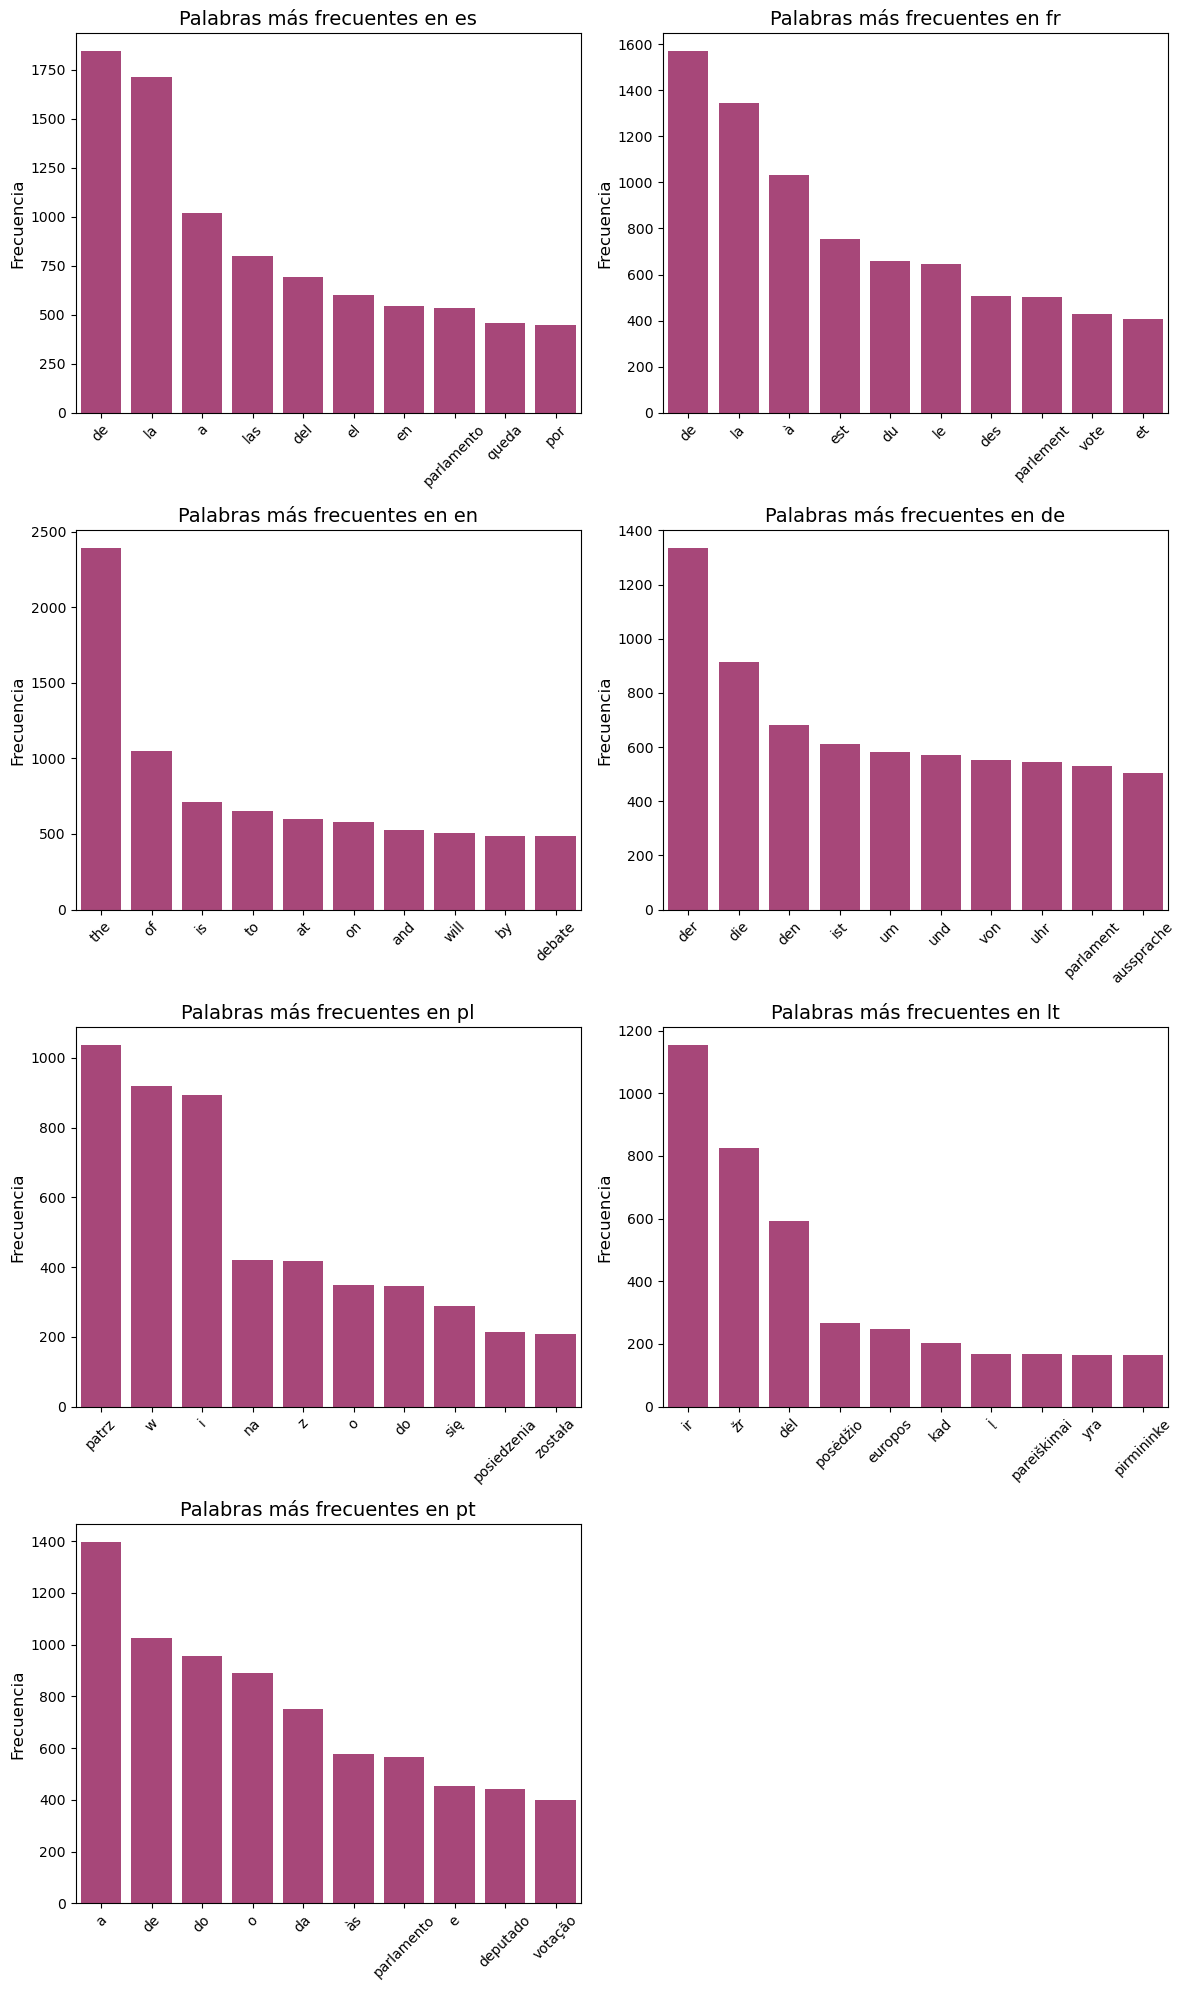

In [12]:
top_words=top_palabras(df_texto)
num_languages = len(top_words)
cols = 2
rows = math.ceil(num_languages / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axes = axes.flatten()
for idx, (lang, freq_list) in enumerate(top_words.items()):
    ax = axes[idx]
    words = [item[0] for item in freq_list]
    frequencies = [item[1] for item in freq_list]
    data = pd.DataFrame({
        'Palabra': words,
        'Frecuencia': frequencies,
        'Grupo': lang
    })

    sns.barplot(
        data=data,
        x='Palabra',
        y='Frecuencia',
        hue='Grupo',
        palette='magma',
        ax=ax,
        legend=False
    )

    ax.set_title(f'Palabras más frecuentes en {lang}', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Frecuencia', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

# Ocultamos los ejes que han quedado vacios
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Al analizar las palabras más frecuentes por idioma, se observa que predominan elementos funcionales como artículos y preposiciones, lo cual era previsible. Un ejemplo llamativo es la palabra "de", que aparece con alta frecuencia en múltiples idiomas, lo que indica que no será útil como rasgo distintivo para identificar un idioma en particular.

En cambio, las palabras que resultan más valiosas para la clasificación son aquellas que aparecen con regularidad en un idioma pero están ausentes, o son mucho menos frecuentes, en los demás. Estas palabras aportan información diferencial y ayudan a distinguir los idiomas entre sí.

Precisamente esta idea es la base de la técnica TF-IDF (Term Frequency–Inverse Document Frequency). En lugar de considerar solo cuántas veces aparece una palabra, TF-IDF también evalúa cuán exclusiva es dentro del conjunto de documentos.

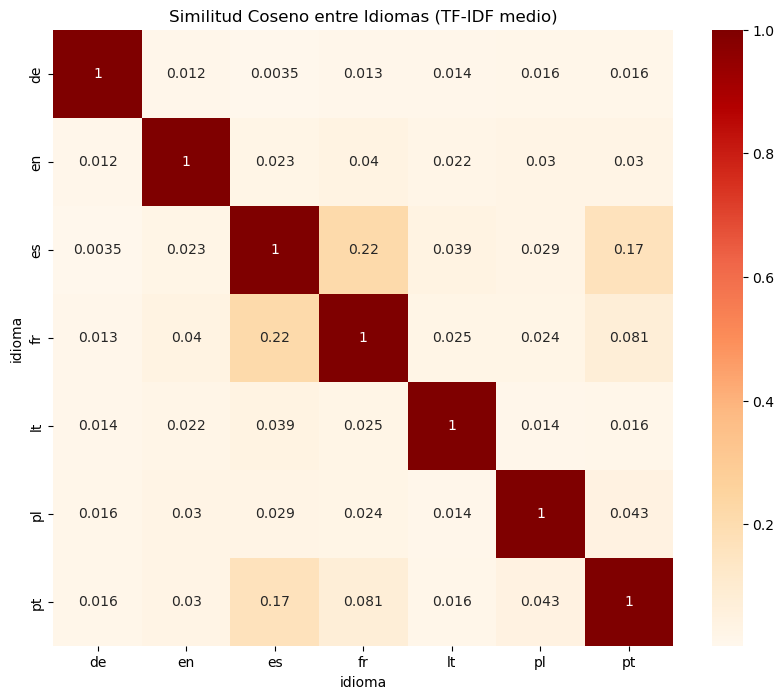

Ranking de idiomas según similitud media con el resto:
    Similitud_Media
es         0.079820
fr         0.066611
pt         0.058821
en         0.026195
pl         0.026053
lt         0.021654
de         0.012372


In [14]:
# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        min_df=2,
        ngram_range=(1, 2)
    )
X_tfidf = tfidf_vectorizer.fit_transform(df_texto["Texto"])

# Crear un dataframe e identificamos los idiomas
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_tfidf["idioma"] = df_texto["Idioma"].values

# Calcular vector promedio por idioma
mean_vectors = df_tfidf.groupby("idioma").mean()

# Similitud coseno entre idiomas
similarity_matrix = cosine_similarity(mean_vectors)
sim_df = pd.DataFrame(similarity_matrix, index=mean_vectors.index, columns=mean_vectors.index)

# Visualizar matriz de similitud
plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap="OrRd")
plt.title("Similitud Coseno entre Idiomas (TF-IDF medio)")
plt.show()

# Calcular la similitud media con el resto de idiomas
similaridad_media = {}

for idioma in sim_df.index:
    similitudes = sim_df.loc[idioma].drop(idioma)  # Excluye la diagonal
    similaridad_media[idioma] = similitudes.mean()

# Convertir a DataFrame para visualizar el ranking
ranking_similitud = pd.DataFrame.from_dict(similaridad_media, orient='index', columns=['Similitud_Media'])
ranking_similitud = ranking_similitud.sort_values(by='Similitud_Media', ascending=False)

# Mostrar ranking
print("Ranking de idiomas según similitud media con el resto:")
print(ranking_similitud)

Codifiquemos la variable objetivo y realicemos una partición del conjunto de datos en entrenamiento, validación y test. 

In [16]:
cod_to_id = {cod: id for id,cod in enumerate(df_texto['Idioma'].unique())}
id_to_cod= {id: cod for id,cod in cod_to_id.items()}

df_texto["Cod_Idiom"]=df_texto['Idioma'].map(cod_to_id)


In [17]:
X=df_texto["Texto"]
y=df_texto["Cod_Idiom"]

X_train, X_rest, y_train, y_rest =train_test_split(X,y,test_size=0.30,stratify=y,random_state=42) 
X_test, X_val, y_test, y_val =train_test_split(X_rest,y_rest,test_size=0.5,stratify=y_rest,random_state=42) 

print("Tamaños:")
print("Entrenamiento:", len(X_train))
print("Validación:   ", len(X_val))
print("Test:         ", len(X_test))

Tamaños:
Entrenamiento: 24500
Validación:    5250
Test:          5250


## Representación vectorial

Para que los modelos automáticos sean capaces de procesar los textos es necesario transformarlos con una representación numérica. Por ello debemos transformar las secuencias lingüísticas en vectores que capturen las características textuales más relevantes. Veamos qué transformación vectorial es la idónea. 

In [19]:
def entrena_clasificador(clasificador, X_train, y_train, X_val, y_val):
    clasificador.fit(X_train, y_train)
    y_pred = clasificador.predict(X_val)
    accuracy = np.mean(y_pred == y_val)
    print(f"  Accuracy inicial: {accuracy:.4f}")
    print("-" * 50)
    return clasificador, accuracy


def vectoriza_entrena(X_train,X_val,y_train,y_val,tipo_vector, clasificador):
    if tipo_vector == 'chars-tf-idf':
        vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))

    elif tipo_vector == 'words-tf-idf':
        vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))

    elif tipo_vector == 'hashing':
        vectorizer = HashingVectorizer(analyzer='char', ngram_range=(2, 4), n_features=2**18, alternate_sign=False)

    else:
        raise ValueError(f"Técnica de vectorización '{tipo_vector}' no reconocida.")
    pipeline = make_pipeline(vectorizer, clasificador)
    resultado = entrena_clasificador(pipeline, X_train, y_train, X_val, y_val)
    return resultado

    

Para la elección de la vectorización tomaremos como clasificador Naïve Bayes.

In [21]:
nb_classifier = MultinomialNB()
vectorization_techniques = ['chars-tf-idf', 'words-tf-idf', 'hashing']

results = []
for tech in vectorization_techniques:
    print(f"\n Evaluando {tech}...")
    trained_classifier, accuracy = vectoriza_entrena(X_train, X_val, y_train, y_val, f"{tech}",nb_classifier
    )

    results.append({
        'Tecnica Vectorizacion': tech,
        'Accuracy': accuracy
    })
results_df = pd.DataFrame(results)

print("\n--- Resultados Comparativos ---")
display(results_df)


 Evaluando chars-tf-idf...
  Accuracy inicial: 0.9762
--------------------------------------------------

 Evaluando words-tf-idf...
  Accuracy inicial: 0.9758
--------------------------------------------------

 Evaluando hashing...
  Accuracy inicial: 0.9747
--------------------------------------------------

--- Resultados Comparativos ---


,Tecnica Vectorizacion,Accuracy
0,chars-tf-idf,0.976190
1,words-tf-idf,0.975810
2,hashing,0.974667


Tomaremos por tanto la vectorización por carcater. 

## Entrenamiento de Clasificadores
Una vez seleccionada la vectorización, pasemos a seleccionar que modelo capta mejor las características del dataset. 

In [23]:


# Hiperparámetros a evaluar
ngram_ranges = [(1,2),(2, 2), (3, 3), (4, 4)]
C_values = [0.1, 1, 10]  #  LogisticRegression
alphas = [0.1, 1, 10]    # MultinomialNB

# Para guardar el mejor modelo
mejor_accuracy = 0
mejor_modelo = None
mejores_parametros = {}

# Evaluar Logistic Regression

for ngram in ngram_ranges:
    for C in C_values:
        print(f"Entrenando LogisticRegression con ngram={ngram}, C={C}")
        
        pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(analyzer='char', ngram_range=ngram)),
            ('clf', LogisticRegression(C=C, max_iter=1000))
        ])
        
        pipeline.fit(X_train, y_train)
        y_val_pred = pipeline.predict(X_val)
        acc = accuracy_score(y_val, y_val_pred)
        
        print(f"Accuracy en validación: {acc:.4f}")
        
        if acc > mejor_accuracy:
            mejor_accuracy = acc
            mejor_modelo = pipeline
            mejores_parametros = {
                'modelo': 'LogisticRegression',
                'ngram_range': ngram,
                'C': C
            }


# Evaluar Naive Bayes

for ngram in ngram_ranges:
    for alpha in alphas:
        print(f"Entrenando MultinomialNB con ngram={ngram}, alpha={alpha}")
        
        pipeline = Pipeline([
            ('vectorizer',  TfidfVectorizer(analyzer='char', ngram_range=ngram)),
            ('clf', MultinomialNB(alpha=alpha))
        ])
        
        pipeline.fit(X_train, y_train)
        y_val_pred = pipeline.predict(X_val)
        acc = accuracy_score(y_val, y_val_pred)
        
        print(f"Accuracy en validación: {acc:.4f}")
        
        if acc > mejor_accuracy:
            mejor_accuracy = acc
            mejor_modelo = pipeline
            mejores_parametros = {
                'modelo': 'MultinomialNB',
                'ngram_range': ngram,
                'alpha': alpha
            }


# Resultados finales

print("\nMejores hiperparámetros encontrados:")
print(mejores_parametros)
print(f"Accuracy en validación: {mejor_accuracy:.4f}")



Entrenando LogisticRegression con ngram=(1, 2), C=0.1
Accuracy en validación: 0.9629
Entrenando LogisticRegression con ngram=(1, 2), C=1
Accuracy en validación: 0.9705
Entrenando LogisticRegression con ngram=(1, 2), C=10
Accuracy en validación: 0.9718
Entrenando LogisticRegression con ngram=(2, 2), C=0.1
Accuracy en validación: 0.9650
Entrenando LogisticRegression con ngram=(2, 2), C=1
Accuracy en validación: 0.9697
Entrenando LogisticRegression con ngram=(2, 2), C=10
Accuracy en validación: 0.9705
Entrenando LogisticRegression con ngram=(3, 3), C=0.1
Accuracy en validación: 0.9737
Entrenando LogisticRegression con ngram=(3, 3), C=1
Accuracy en validación: 0.9770
Entrenando LogisticRegression con ngram=(3, 3), C=10
Accuracy en validación: 0.9743
Entrenando LogisticRegression con ngram=(4, 4), C=0.1
Accuracy en validación: 0.9741
Entrenando LogisticRegression con ngram=(4, 4), C=1
Accuracy en validación: 0.9770
Entrenando LogisticRegression con ngram=(4, 4), C=10
Accuracy en validación:

Concluimos por tanto que el mejor modelo es el 3-gramma con regresión logística. Vamos a construir el modelo final utilizando el conjunto de entrenamiento y validación, con los parámetros obtenidos. Evaluemos el modelo final y procedamos a guardarlo.

In [25]:
def evaluar_modelo(modelo, X, y, etiquetas, conjunto='Validación', df=None):
    """
    Evalúa el modelo en un conjunto de datos.
    
    Args:
        modelo: Modelo entrenado
        X: Datos de entrada
        y: Etiquetas reales
        etiquetas: Nombres de las clases
        conjunto: Nombre del conjunto (para mostrar)
        df: DataFrame con textos originales (opcional para mostrar ejemplos)
        
    Returns:
        Métricas de evaluación
    """
    # Convertimos a array si es necesario
    if not isinstance(X, np.ndarray):
        X_array = X.toarray()
    else:
        X_array = X
    
    # Predicciones
    y_pred_prob = modelo.predict_proba(X_array)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Métricas
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred, target_names=etiquetas, output_dict=True)
    
    # Visualizamos matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=etiquetas, yticklabels=etiquetas)
    plt.title(f'Matriz de Confusión - Conjunto de {conjunto}', fontsize=14)
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Etiqueta Predicha', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Mostramos métricas
    print(f"Resultados en conjunto de {conjunto}:")
    print(f"Precisión global: {accuracy:.4f}\n")
    print("Métricas por clase:")
    
    # Creamos DataFrame para mejor visualización
    metrics_df = pd.DataFrame({
        'Precision': [report[label]['precision'] for label in etiquetas],
        'Recall': [report[label]['recall'] for label in etiquetas],
        'F1-Score': [report[label]['f1-score'] for label in etiquetas],
        'Support': [report[label]['support'] for label in etiquetas]
    }, index=etiquetas)
    
    display(metrics_df)
    
    # Visualizamos métricas principales
    plt.figure(figsize=(12, 5))
    
    # Precision, Recall, F1 por clase
    metrics_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 5))
    plt.title(f'Métricas por Clase - Conjunto de {conjunto}', fontsize=14)
    plt.ylabel('Valor', fontsize=12)
    plt.xlabel('Idioma', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Métrica')
    plt.tight_layout()
    plt.show()
    # Creamos DataFrame para mejor visualización
    metrics_df = pd.DataFrame({
        'Precision': [report[label]['precision'] for label in etiquetas],
        'Recall': [report[label]['recall'] for label in etiquetas],
        'F1-Score': [report[label]['f1-score'] for label in etiquetas],
        'Support': [report[label]['support'] for label in etiquetas]
    }, index=etiquetas)

    display(metrics_df)

   
    # Análisis de ejemplos incorrectos
    incorrect_indices = np.where(y != y_pred)[0]
    if len(incorrect_indices) > 0 and df is not None:
        print(f"\nEjemplos incorrectamente clasificados ({len(incorrect_indices)}):")
        
        # Mostramos algunos ejemplos representativos
        # Elegimos hasta 5 ejemplos, priorizando diversidad de clases
        selected_indices = []
        seen_pairs = set()
        
        for idx in incorrect_indices:
            true_label = y.iloc[idx]
            pred_label = y_pred[idx]
            pair = (true_label, pred_label)
            
            if pair not in seen_pairs and len(selected_indices) < 5:
                seen_pairs.add(pair)
                selected_indices.append(idx)
        
        # Si no tenemos 5 ejemplos todavía, añadimos más
        remaining = 5 - len(selected_indices)
        if remaining > 0 and len(incorrect_indices) > len(selected_indices):
            additional_indices = [idx for idx in incorrect_indices if idx not in selected_indices]
            selected_indices.extend(additional_indices[:remaining])
        
        # Mostramos los ejemplos seleccionados
        for idx in selected_indices:
            texto = df.iloc[idx]['text']
            idioma_real = etiquetas[y.iloc[idx]]
            idioma_pred = etiquetas[y_pred[idx]]
            prob = y_pred_prob[idx][y_pred[idx]]
            
            print(f"\nTexto: '{texto}'")
            print(f"  - Idioma real: {idioma_real}")
            print(f"  - Iidioma predicho: {idioma_pred}")
            print(f"  - Confianza: {prob:.4f}")
            
            # Mostramos top 3 predicciones
            top3_idx = np.argsort(y_pred_prob[idx])[::-1][:3]
            print("  - Top 3 predicciones:")
            for i, pred_idx in enumerate(top3_idx, 1):
                print(f"    {i}. {etiquetas[pred_idx]}: {y_pred_prob[idx][pred_idx]:.4f}")
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob
    }

  Accuracy inicial: 0.9790
--------------------------------------------------


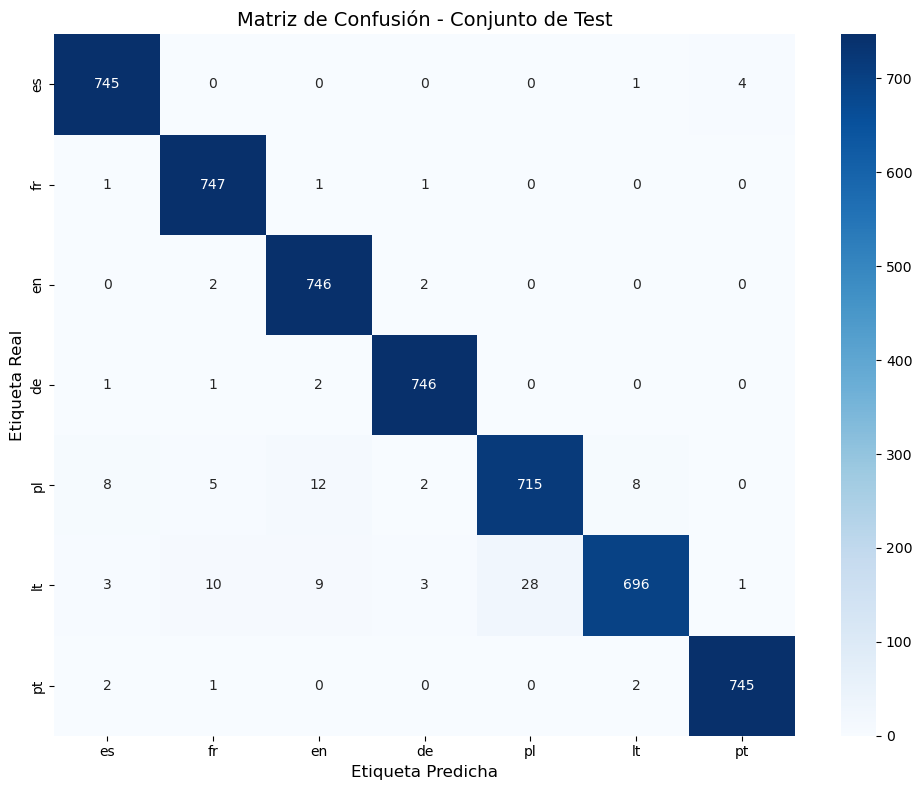

Resultados en conjunto de Test:
Precisión global: 0.9790

Métricas por clase:


,Precision,Recall,F1-Score,Support
es,0.980263,0.993333,0.986755,750.0
fr,0.975196,0.996000,0.985488,750.0
en,0.968831,0.994667,0.981579,750.0
de,0.989390,0.994667,0.992021,750.0
pl,0.962315,0.953333,0.957803,750.0
lt,0.984441,0.928000,0.955388,750.0
pt,0.993333,0.993333,0.993333,750.0


<Figure size 1200x500 with 0 Axes>

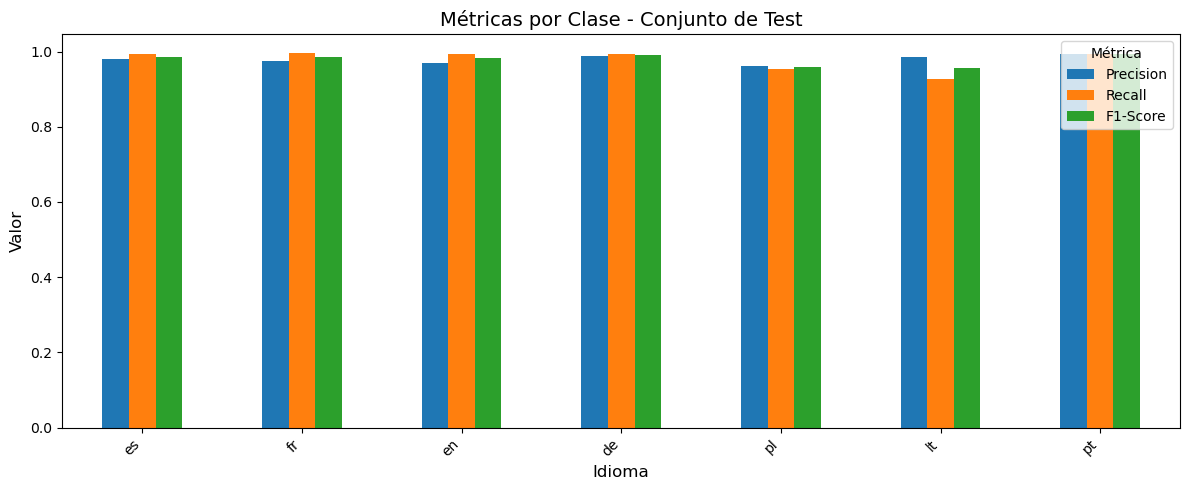

,Precision,Recall,F1-Score,Support
es,0.980263,0.993333,0.986755,750.0
fr,0.975196,0.996000,0.985488,750.0
en,0.968831,0.994667,0.981579,750.0
de,0.989390,0.994667,0.992021,750.0
pl,0.962315,0.953333,0.957803,750.0
lt,0.984441,0.928000,0.955388,750.0
pt,0.993333,0.993333,0.993333,750.0



Ejemplos incorrectamente clasificados (110):

Texto: 'συνεδρίαση λήγει στις  μμ'
  - Idioma real: pl
  - Iidioma predicho: lt
  - Confianza: 0.4686
  - Top 3 predicciones:
    1. lt: 0.4686
    2. pl: 0.3017
    3. en: 0.0482

Texto: 'report jacek saryuszwolski'
  - Idioma real: lt
  - Iidioma predicho: pl
  - Confianza: 0.5280
  - Top 3 predicciones:
    1. pl: 0.5280
    2. lt: 0.3028
    3. en: 0.0859

Texto: 'i declare adjourned the session of the european parliament'
  - Idioma real: lt
  - Iidioma predicho: en
  - Confianza: 0.9543
  - Top 3 predicciones:
    1. en: 0.9543
    2. pl: 0.0293
    3. lt: 0.0109

Texto: 'região administrativa especial de hong kong'
  - Idioma real: pt
  - Iidioma predicho: es
  - Confianza: 0.4166
  - Top 3 predicciones:
    1. es: 0.4166
    2. pt: 0.2531
    3. en: 0.0873

Texto: 'o o o'
  - Idioma real: lt
  - Iidioma predicho: pt
  - Confianza: 0.5921
  - Top 3 predicciones:
    1. pt: 0.5921
    2. pl: 0.2059
    3. lt: 0.1078


{'accuracy': 0.979047619047619,
 'confusion_matrix': array([[745,   0,   0,   0,   0,   1,   4],
        [  1, 747,   1,   1,   0,   0,   0],
        [  0,   2, 746,   2,   0,   0,   0],
        [  1,   1,   2, 746,   0,   0,   0],
        [  8,   5,  12,   2, 715,   8,   0],
        [  3,  10,   9,   3,  28, 696,   1],
        [  2,   1,   0,   0,   0,   2, 745]], dtype=int64),
 'classification_report': {'es': {'precision': 0.9802631578947368,
   'recall': 0.9933333333333333,
   'f1-score': 0.9867549668874173,
   'support': 750.0},
  'fr': {'precision': 0.9751958224543081,
   'recall': 0.996,
   'f1-score': 0.9854881266490765,
   'support': 750.0},
  'en': {'precision': 0.9688311688311688,
   'recall': 0.9946666666666667,
   'f1-score': 0.9815789473684211,
   'support': 750.0},
  'de': {'precision': 0.9893899204244032,
   'recall': 0.9946666666666667,
   'f1-score': 0.9920212765957447,
   'support': 750.0},
  'pl': {'precision': 0.9623149394347241,
   'recall': 0.9533333333333334,
   

In [26]:
# Unimos entrenamiento y validación
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
X_train_val_vec = vectorizer.fit_transform(X_trainval)
X_test_vec = vectorizer.transform(X_test)
df_test = pd.DataFrame({
    'text': X_test,
    'etiqueta': y_test
})

# Construimos el modelo final con los mejores hiperparámetros

modelo_final,_ = entrena_clasificador(LogisticRegression(C=1),X_train_val_vec,y_trainval,X_test_vec,y_test)
evaluar_modelo(modelo_final,X_test_vec,y_test,df_texto['Idioma'].unique(),conjunto="Test",df=df_test)


En términos generales, el modelo ha logrado una clasificación satisfactoria para la mayoría de los idiomas. Tal como se observó previamente, el español presenta un mayor nivel de confusión con respecto a otros idiomas. No obstante, resulta especialmente destacable la cantidad de errores cometidos entre el lituano y el polaco. A pesar de no presentar una similitud lingüística directa, el modelo ha mostrado una tasa de confusión significativamente superior entre estas dos lenguas en comparación con el resto. 

Inicialmente se realizó una comparación con bigramas y unigramas. Veamos qué ocurre con los trigramas.

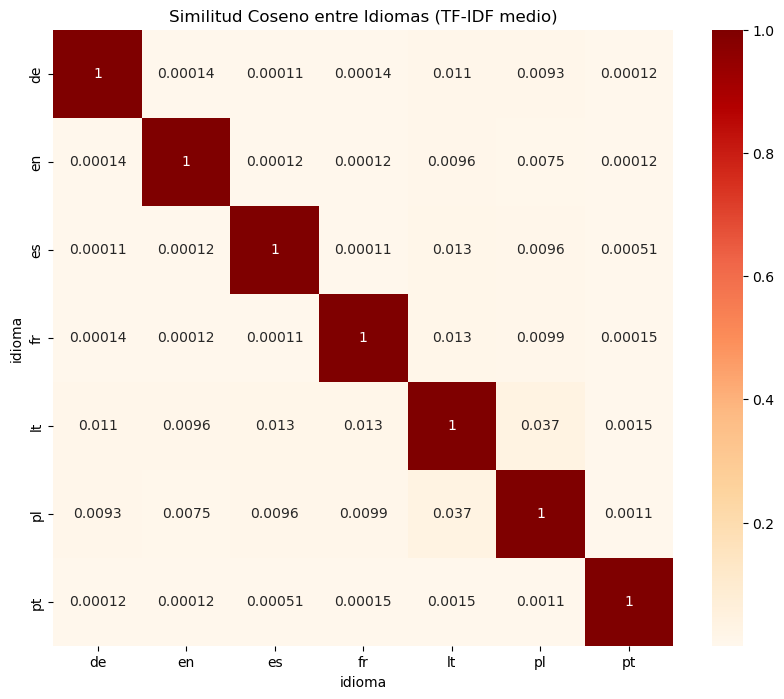

Ranking de idiomas según similitud media con el resto:
    Similitud_Media
lt         0.014125
pl         0.012433
fr         0.003907
es         0.003837
de         0.003429
en         0.002928
pt         0.000573


In [28]:
tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        min_df=2,
        ngram_range=(3,3)
    )
X_tfidf = tfidf_vectorizer.fit_transform(df_texto["Texto"])

# Crear un dataframe e identificamos los idiomas
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_tfidf["idioma"] = df_texto["Idioma"].values

# Calcular vector promedio por idioma
mean_vectors = df_tfidf.groupby("idioma").mean()

# Similitud coseno entre idiomas
similarity_matrix = cosine_similarity(mean_vectors)
sim_df = pd.DataFrame(similarity_matrix, index=mean_vectors.index, columns=mean_vectors.index)

# Visualizar matriz de similitud
plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap="OrRd")
plt.title("Similitud Coseno entre Idiomas (TF-IDF medio)")
plt.show()

# Calcular la similitud media con el resto de idiomas
similaridad_media = {}

for idioma in sim_df.index:
    similitudes = sim_df.loc[idioma].drop(idioma)  # Excluye la diagonal
    similaridad_media[idioma] = similitudes.mean()

# Convertir a DataFrame para visualizar el ranking
ranking_similitud = pd.DataFrame.from_dict(similaridad_media, orient='index', columns=['Similitud_Media'])
ranking_similitud = ranking_similitud.sort_values(by='Similitud_Media', ascending=False)

# Mostrar ranking
print("Ranking de idiomas según similitud media con el resto:")
print(ranking_similitud)

Efectivamente al aumentar el número de n-gramma la similitud entre el polaco y el lituano aumenta, y en el resto de idiomas disminuye considerablemente.

In [30]:
joblib.dump(modelo_final, 'modelo_final.pkl')
joblib.dump(vectorizer, 'vectorizer_tfidf.pkl')

print("Modelo y vectorizador guardados correctamente.")

Modelo y vectorizador guardados correctamente.


## Modelos de Deep Learning

Las redes recurrentes requieren un preprocesamiento diferente basado en secuencias de tokens. Definamos una función para ello.

In [33]:
def preprocesar_secuencias(textos_train, textos_val, textos_test, max_palabras=10000, max_longitud=None):
    """
    Preprocesa textos para modelos recurrentes mediante tokenización y padding.
    
    Args:
        textos_train: Lista de textos de entrenamiento
        textos_val: Lista de textos de validación
        textos_test: Lista de textos de prueba
        max_palabras: Tamaño máximo del vocabulario
        max_longitud: Longitud máxima de las secuencias (si es None, se calcula automáticamente)
        
    Returns:
        Datos preprocesados y tokenizador
    """
    # Inicializamos el tokenizador
    tokenizer = Tokenizer(num_words=max_palabras, oov_token="<OOV>")
    
    # Ajustamos el tokenizador en los datos de entrenamiento
    tokenizer.fit_on_texts(textos_train)
    
    # Convertimos textos a secuencias
    secuencias_train = tokenizer.texts_to_sequences(textos_train)
    secuencias_val = tokenizer.texts_to_sequences(textos_val)
    secuencias_test = tokenizer.texts_to_sequences(textos_test)
    
    # Determinamos longitud máxima si no se especifica
    if max_longitud is None:
        longitudes = [len(seq) for seq in secuencias_train]
        max_longitud = int(np.percentile(longitudes, 95))  # Usamos el percentil 95 para evitar outliers
    
    # Realizamos padding
    X_train = pad_sequences(secuencias_train, maxlen=max_longitud, padding='post')
    X_val = pad_sequences(secuencias_val, maxlen=max_longitud, padding='post')
    X_test = pad_sequences(secuencias_test, maxlen=max_longitud, padding='post')
    
    # Información sobre el vocabulario
    vocab_size = min(max_palabras, len(tokenizer.word_index) + 1)
    palabra_a_indice = tokenizer.word_index
    indice_a_palabra = {v: k for k, v in palabra_a_indice.items()}
    
    print(f"Preprocesamiento completado:")
    print(f"- Tamaño del vocabulario: {vocab_size} palabras")
    print(f"- Longitud máxima de secuencia: {max_longitud} tokens")
    print(f"- Ejemplos de tokenización:")
    
    # Mostramos ejemplos
    for i in range(min(3, len(textos_train))):
        texto = textos_train[i]
        secuencia = secuencias_train[i]
        tokens = [indice_a_palabra.get(idx, "<PAD>") if idx != 0 else "<PAD>" for idx in X_train[i]]
        
        print(f"  Texto: '{texto}'")
        print(f"  Secuencia: {secuencia}")
        print(f"  Con padding: {X_train[i]}")
        print(f"  Tokens: {tokens}\n")
    
    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'tokenizer': tokenizer,
        'vocab_size': vocab_size,
        'max_length': max_longitud,
        'word_index': palabra_a_indice,
        'index_word': indice_a_palabra
    }


In [34]:
df_train= pd.DataFrame({
    'text': X_train,
    'etiqueta': y_train
})
df_val = pd.DataFrame({
    'text': X_val,
    'etiqueta': y_val
})

# Realizamos el preprocesamiento de secuencias
print("Preprocesando datos para redes recurrentes...")
secuencias_data = preprocesar_secuencias(
    df_train['text'].values,
    df_val['text'].values,
    df_test['text'].values,
    max_palabras=100
)


Preprocesando datos para redes recurrentes...
Preprocesamiento completado:
- Tamaño del vocabulario: 100 palabras
- Longitud máxima de secuencia: 14 tokens
- Ejemplos de tokenización:
  Texto: 'seien sie versichert dass wir ihnen aufmerksam zuhören werden'
  Secuencia: [1, 1, 1, 1, 1, 1, 1, 1, 1]
  Con padding: [1 1 1 1 1 1 1 1 1 0 0 0 0 0]
  Tokens: ['<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<OOV>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

  Texto: 'parliament approved the legislative resolution'
  Secuencia: [60, 1, 5, 1, 89]
  Con padding: [60  1  5  1 89  0  0  0  0  0  0  0  0  0]
  Tokens: ['parliament', '<OOV>', 'the', '<OOV>', 'resolution', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

  Texto: 'le parlement adopte la résolution'
  Secuencia: [7, 64, 1, 4, 77]
  Con padding: [ 7 64  1  4 77  0  0  0  0  0  0  0  0  0]
  Tokens: ['le', 'parlement', '<OOV>', 'la', 'résolution', '<PAD>', '<PAD>', '<PAD>', '<PA

In [35]:
def visualizar_longitudes_secuencia(secuencias, titulo="Distribución de Longitudes de Secuencia"):
    """
    Visualiza la distribución de longitudes de las secuencias.
    
    Args:
        secuencias: Lista de secuencias
        titulo: Título del gráfico
    """
    longitudes = [len(seq) for seq in secuencias]
    
    plt.figure(figsize=(10, 6))
    
    # Histograma
    sns.histplot(longitudes, bins=30, kde=True)
    
    # Estadísticas
    plt.axvline(x=np.mean(longitudes), color='r', linestyle='--', 
                label=f'Media: {np.mean(longitudes):.1f}')
    plt.axvline(x=np.median(longitudes), color='g', linestyle='--', 
                label=f'Mediana: {np.median(longitudes):.1f}')
    plt.axvline(x=np.percentile(longitudes, 95), color='b', linestyle='--', 
                label=f'Percentil 95: {np.percentile(longitudes, 95):.1f}')
    
    plt.title(titulo, fontsize=14)
    plt.xlabel('Longitud de la secuencia (tokens)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Estadísticas detalladas
    print(f"Estadísticas de longitud de secuencias:")
    print(f"- Mínima: {np.min(longitudes)}")
    print(f"- Media: {np.mean(longitudes):.2f}")
    print(f"- Mediana: {np.median(longitudes)}")
    print(f"- Máxima: {np.max(longitudes)}")
    print(f"- Desviación estándar: {np.std(longitudes):.2f}")
    print(f"- Percentil 95: {np.percentile(longitudes, 95)}")
    print(f"- Total secuencias: {len(longitudes)}")
    
    # Proporción de secuencias que se truncarán con el max_length
    if 'max_length' in locals():
        secuencias_truncadas = sum(l > max_length for l in longitudes)
        porcentaje_truncado = (secuencias_truncadas / len(longitudes)) * 100
        print(f"- Secuencias truncadas con max_length={max_length}: {secuencias_truncadas} ({porcentaje_truncado:.2f}%)")

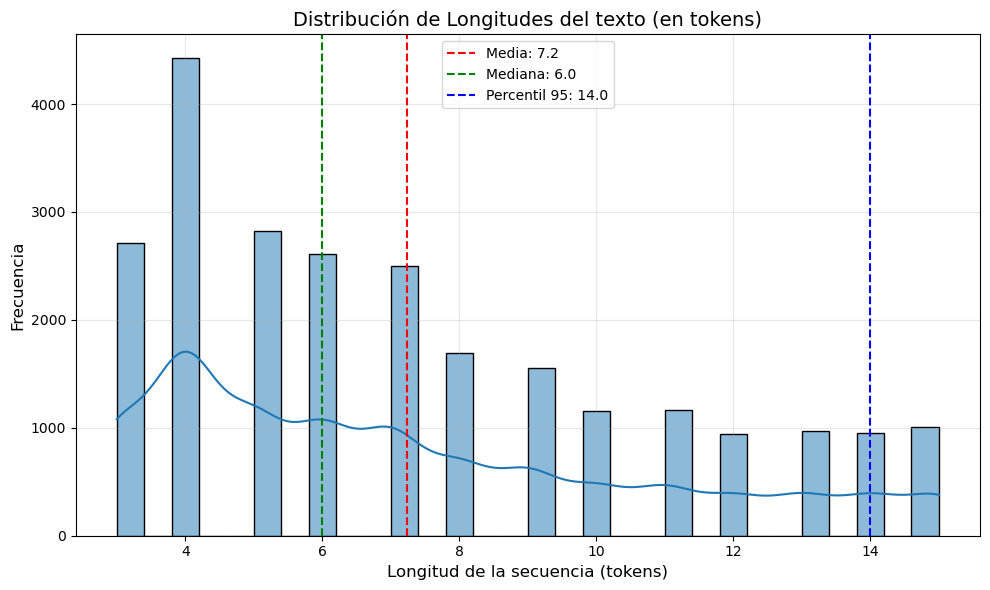

Estadísticas de longitud de secuencias:
- Mínima: 3
- Media: 7.23
- Mediana: 6.0
- Máxima: 15
- Desviación estándar: 3.51
- Percentil 95: 14.0
- Total secuencias: 24500


In [36]:
textos_tokens = secuencias_data['tokenizer'].texts_to_sequences(df_train['text'].values)
visualizar_longitudes_secuencia(textos_tokens, "Distribución de Longitudes del texto (en tokens)")

Observamos que la longitud de las secuencias son las deseadas.

Procedamos a construir un modelo RNN simple para comparalo posteriormente con el modelo LSTM bidireccional. 

In [38]:
def preparar_datos_recurrentes():
    """
    Prepara los datos para el entrenamiento de modelos recurrentes.
    
    Returns:
        Diccionario con datos y configuración
    """
    # Obtenemos secuencias (X) y etiquetas (y)
    X_train = secuencias_data['X_train']
    X_val = secuencias_data['X_val']
    X_test = secuencias_data['X_test']
    
    # Obtenemos etiquetas
    y_train = df_train['etiqueta'].values
    y_val = df_val['etiqueta'].values
    y_test = df_test['etiqueta'].values
    
    # Parámetros para la arquitectura
    vocab_size = secuencias_data['vocab_size']
    max_length = secuencias_data['max_length']
    embedding_dim = 100  # Dimensión de los embeddings
    
    # Obtenemos los nombres de las Idioma
    idiomas = list(cod_to_id.keys())
    
    print(f"Datos recurrentes preparados:")
    print(f"- X_train: {X_train.shape}")
    print(f"- X_val: {X_val.shape}")
    print(f"- X_test: {X_test.shape}")
    print(f"- Vocabulario: {vocab_size} palabras")
    print(f"- Longitud máxima de secuencia: {max_length}")
    print(f"- Dimensión de embeddings: {embedding_dim}")
    print(f"- Número de clases (idiomas): {len(idiomas)}")
    
    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'vocab_size': vocab_size,
        'max_length': max_length,
        'embedding_dim': embedding_dim,
        'num_classes': len(idiomas),
        'idiomas': idiomas,
        'tokenizer': secuencias_data['tokenizer']
    }

In [39]:
# Preparamos los datos
datos_recurrentes = preparar_datos_recurrentes()

Datos recurrentes preparados:
- X_train: (24500, 14)
- X_val: (5250, 14)
- X_test: (5250, 14)
- Vocabulario: 100 palabras
- Longitud máxima de secuencia: 14
- Dimensión de embeddings: 100
- Número de clases (idiomas): 7


In [40]:
def crear_modelo_rnn_simple(vocab_size, embedding_dim, max_length, num_classes, dropout_rate=0.3):
    """
    Crea un modelo RNN simple para detección de Idioma.
    
    Args:
        vocab_size: Tamaño del vocabulario
        embedding_dim: Dimensión de los embeddings
        max_length: Longitud máxima de las secuencias
        num_classes: Número de clases (Idioma)
        dropout_rate: Tasa de dropout para regularización
        
    Returns:
        Modelo compilado
    """
    model = Sequential()
    
    # Capa de embedding
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
    ))
    
    # Capa RNN simple
    model.add(SimpleRNN(
        units=64,
        activation='tanh',
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate
    ))
    
    # Capa de dropout
    model.add(Dropout(dropout_rate))
    
    # Capa densa de salida
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilamos el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Mostramos el resumen
    model.summary()
    
    return model

In [41]:
modelo_rnn_simple = crear_modelo_rnn_simple(
    vocab_size=datos_recurrentes['vocab_size'],
    embedding_dim=datos_recurrentes['embedding_dim'],
    max_length=datos_recurrentes['max_length'],
    num_classes=datos_recurrentes['num_classes']
)

C:\Users\maria\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
def entrenar_modelo_recurrente(modelo, datos, nombre_modelo, epochs=15, batch_size=32):
    """
    Entrena un modelo recurrente con early stopping y reducción de learning rate.
    
    Args:
        modelo: Modelo a entrenar
        datos: Diccionario con datos de entrenamiento y validación
        nombre_modelo: Nombre para guardar el modelo
        epochs: Número máximo de épocas
        batch_size: Tamaño del batch
        
    Returns:
        Historia del entrenamiento
    """
    # Callbacks
    callbacks = [
        # Early stopping para detener cuando no hay mejora
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reducción de learning rate cuando se estanca
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=0.00001
        ),
        
    ]
    
    # Entrenamos el modelo
    history = modelo.fit(
        datos['X_train'], datos['y_train'],
        validation_data=(datos['X_val'], datos['y_val']),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [43]:
print("\nEntrenando modelo RNN simple:")
history_rnn_simple = entrenar_modelo_recurrente(
    modelo_rnn_simple,
    datos_recurrentes,
    "modelo_rnn_simple"
)


Entrenando modelo RNN simple:
Epoch 1/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2464 - loss: 1.8483 - val_accuracy: 0.6330 - val_loss: 1.0614 - learning_rate: 0.0010
Epoch 2/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5075 - loss: 1.2888 - val_accuracy: 0.6712 - val_loss: 0.8940 - learning_rate: 0.0010
Epoch 3/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5944 - loss: 1.1075 - val_accuracy: 0.7229 - val_loss: 0.8390 - learning_rate: 0.0010
Epoch 4/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6405 - loss: 1.0123 - val_accuracy: 0.7505 - val_loss: 0.7826 - learning_rate: 0.0010
Epoch 5/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6872 - loss: 0.9293 - val_accuracy: 0.7730 - val_loss: 0.7268 - learning_rate: 0.0010
Epoch 6/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7020 - loss: 0.8864 - val_accuracy: 0.7133 - val_loss: 0.7192 - learning_rate: 0.0010
Epoch 7/15
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc

In [44]:
def visualizar_entrenamiento_recurrente(history, title="Entrenamiento del Modelo"):
    """
    Visualiza la evolución del entrenamiento del modelo.
    
    Args:
        history: Historial del entrenamiento
        title: Título del gráfico
    """
    # Extraemos métricas
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    # Configuramos la figura
    plt.figure(figsize=(14, 5))
    
    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Precisión entrenamiento')
    plt.plot(epochs_range, val_acc, 'ro-', label='Precisión validación')
    plt.title('Precisión de Entrenamiento y Validación', fontsize=12)
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Precisión', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'bo-', label='Pérdida entrenamiento')
    plt.plot(epochs_range, val_loss, 'ro-', label='Pérdida validación')
    plt.title('Pérdida de Entrenamiento y Validación', fontsize=12)
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Pérdida', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()
    
    # Métricas finales
    final_epoch = len(acc)
    print(f"Métricas finales ({final_epoch} épocas):")
    print(f"  Precisión entrenamiento: {acc[-1]:.4f}")
    print(f"  Precisión validación: {val_acc[-1]:.4f}")
    print(f"  Pérdida entrenamiento: {loss[-1]:.4f}")
    print(f"  Pérdida validación: {val_loss[-1]:.4f}")
    
    # Mejor época
    best_epoch = np.argmax(val_acc) + 1
    print(f"\nMejor rendimiento (época {best_epoch}):")
    print(f"  Precisión validación: {max(val_acc):.4f}")
    print(f"  Pérdida validación: {val_loss[best_epoch-1]:.4f}")
    
    # Análisis de sobreajuste
    overfit_gap = acc[-1] - val_acc[-1]
    print(f"\nBrecha de entrenamiento-validación: {overfit_gap:.4f}")
    if overfit_gap > 0.1:
        print("⚠ Posible sobreajuste detectado. Considerar mayor regularización.")
    else:
        print("✓ No hay señales significativas de sobreajuste.")

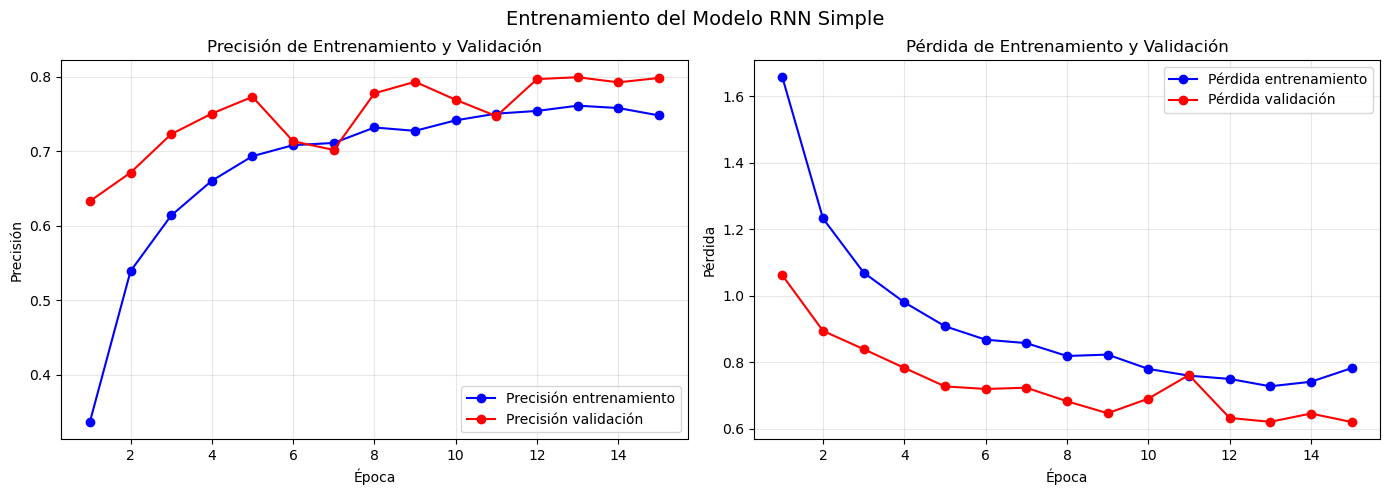

Métricas finales (15 épocas):
  Precisión entrenamiento: 0.7480
  Precisión validación: 0.7983
  Pérdida entrenamiento: 0.7818
  Pérdida validación: 0.6197

Mejor rendimiento (época 13):
  Precisión validación: 0.7992
  Pérdida validación: 0.6202

Brecha de entrenamiento-validación: -0.0503
✓ No hay señales significativas de sobreajuste.


In [45]:
# Visualizamos el entrenamiento
visualizar_entrenamiento_recurrente(
    history_rnn_simple, 
    "Entrenamiento del Modelo RNN Simple"
)

In [46]:
def evaluar_modelo_recurrente(modelo, datos, conjunto='Validación'):
    """
    Evalúa un modelo recurrente en un conjunto de datos.
    
    Args:
        modelo: Modelo entrenado
        datos: Diccionario con datos
        conjunto: 'Validación' o 'Prueba'
        
    Returns:
        Diccionario con métricas de evaluación
    """
    # Seleccionamos datos según el conjunto
    if conjunto.lower() == 'validación' or conjunto.lower() == 'validacion':
        X = datos['X_val']
        y = datos['y_val']
        df = df_val
    else:  # Prueba por defecto
        X = datos['X_test']
        y = datos['y_test']
        df = df_test
    
    # Realizamos predicciones
    y_pred_prob = modelo.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculamos métricas
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred, target_names=datos['idiomas'], output_dict=True)
    
    # Visualizamos matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=datos['idiomas'], yticklabels=datos['idiomas'])
    plt.title(f'Matriz de Confusión - Conjunto de {conjunto}', fontsize=14)
    plt.ylabel('Idioma Real', fontsize=12)
    plt.xlabel('Idiomas Predicho', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Mostramos métricas
    print(f"Resultados en conjunto de {conjunto}:")
    print(f"Precisión global: {accuracy:.4f}\n")
    print("Métricas por clase:")
    
    # Creamos DataFrame para mejor visualización
    metrics_df = pd.DataFrame({
        'Precision': [report[label]['precision'] for label in datos['idiomas']],
        'Recall': [report[label]['recall'] for label in datos['idiomas']],
        'F1-Score': [report[label]['f1-score'] for label in datos['idiomas']],
        'Support': [report[label]['support'] for label in datos['idiomas']]
    }, index=datos['idiomas'])
    
    display(metrics_df)
    
    # Visualizamos métricas principales
    plt.figure(figsize=(12, 5))
    
    # Precision, Recall, F1 por clase
    metrics_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 5))
    plt.title(f'Métricas por Clase - Conjunto de {conjunto}', fontsize=14)
    plt.ylabel('Valor', fontsize=12)
    plt.xlabel('Idioma', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Métrica')
    plt.tight_layout()
    plt.show()
    
    # Analizamos ejemplos incorrectos
    incorrect_indices = np.where(y != y_pred)[0]
    if len(incorrect_indices) > 0:
        print(f"\nEjemplos incorrectamente clasificados ({len(incorrect_indices)}):")
        
        # Mostramos algunos ejemplos representativos
        selected_indices = incorrect_indices[:min(5, len(incorrect_indices))]
        
        for idx in selected_indices:
            # Obtenemos el texto original
            texto_original = df.iloc[idx]['text']
            
            # Convertimos secuencia a tokens
            tokens = []
            for token_id in X[idx]:
                if token_id > 0:  # Ignoramos padding (0)
                    word = datos['tokenizer'].index_word.get(token_id, "<OOV>")
                    tokens.append(word)
            
            texto_tokens = " ".join(tokens)
            
            # Obtenemos Idioma y confianzas
            idioma_real = datos['idiomas'][y[idx]]
            idioma_pred = datos['idiomas'][y_pred[idx]]
            conf_pred = y_pred_prob[idx][y_pred[idx]]
            conf_real = y_pred_prob[idx][y[idx]]
            
            print(f"\nTexto original: '{texto_original}'")
            print(f"Tokens: '{texto_tokens}'")
            print(f"  - Idioma real: {idioma_real}")
            print(f"  - Idioma predicha: {idioma_pred}")
            print(f"  - Confianza en predicción: {conf_pred:.4f}")
            print(f"  - Confianza en idioma real: {conf_real:.4f}")
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob
    }



Evaluando modelo RNN simple:
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


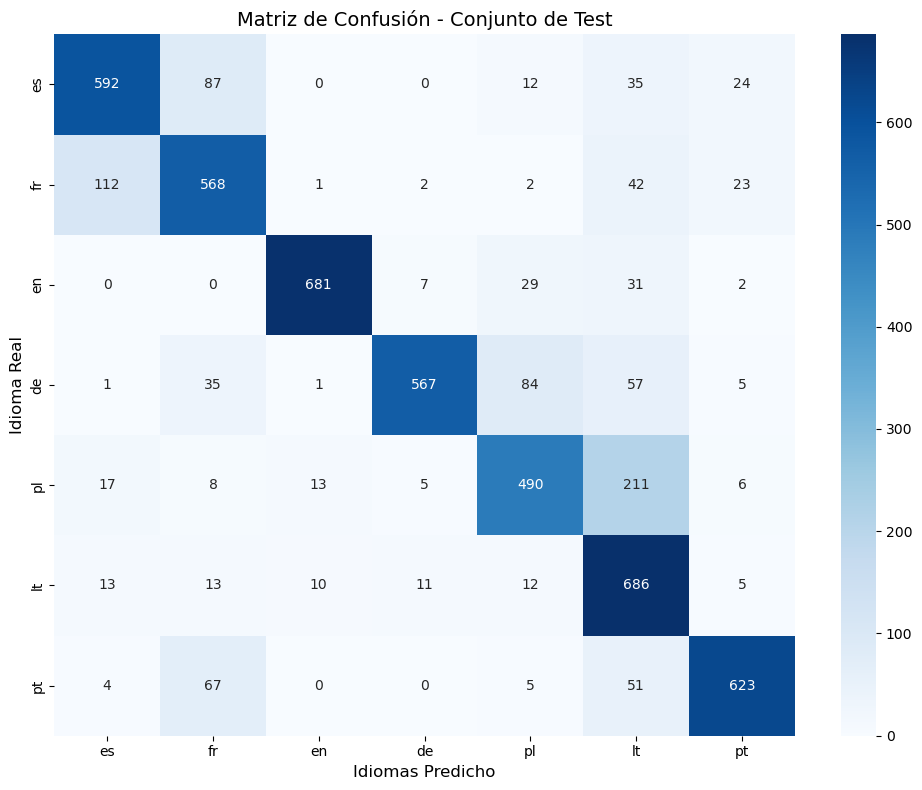

Resultados en conjunto de Test:
Precisión global: 0.8013

Métricas por clase:


,Precision,Recall,F1-Score,Support
es,0.801083,0.789333,0.795165,750.0
fr,0.730077,0.757333,0.743455,750.0
en,0.964589,0.908000,0.935440,750.0
de,0.957770,0.756000,0.845007,750.0
pl,0.772871,0.653333,0.708092,750.0
lt,0.616352,0.914667,0.736447,750.0
pt,0.905523,0.830667,0.866481,750.0


<Figure size 1200x500 with 0 Axes>

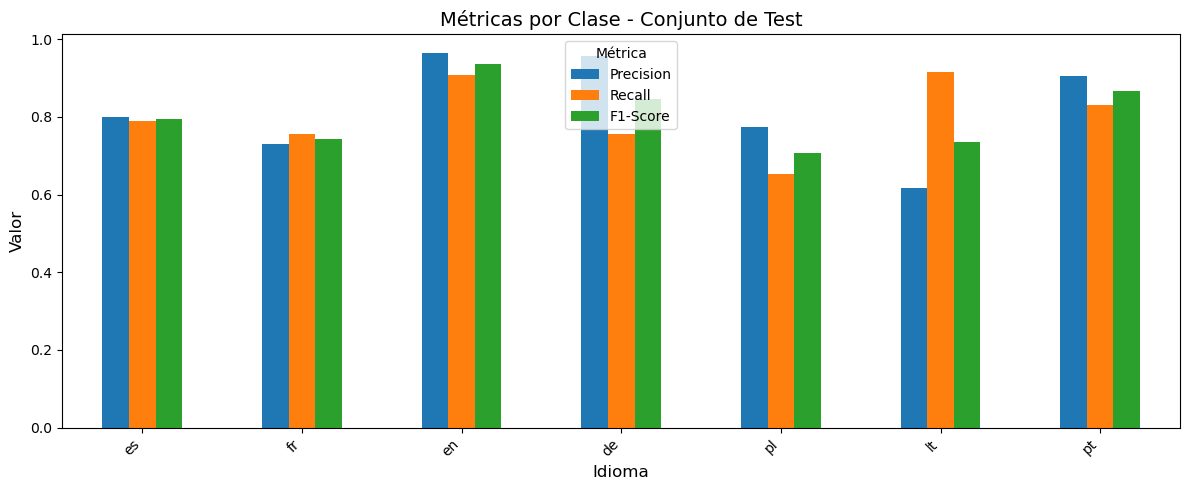


Ejemplos incorrectamente clasificados (1043):

Texto original: 'συνεδρίαση λήγει στις  μμ'
Tokens: '<OOV> <OOV> <OOV> <OOV>'
  - Idioma real: pl
  - Idioma predicha: lt
  - Confianza en predicción: 0.5313
  - Confianza en idioma real: 0.2655

Texto original: 'those entitled to claim family reunification are'
Tokens: '<OOV> <OOV> to <OOV> <OOV> <OOV> <OOV>'
  - Idioma real: en
  - Idioma predicha: pl
  - Confianza en predicción: 0.3773
  - Confianza en idioma real: 0.1470

Texto original: 'je déclare reprise la session du parlement européen qui avait été interrompue le vendredi  février'
Tokens: '<OOV> <OOV> la <OOV> du parlement <OOV> <OOV> <OOV> <OOV> <OOV> le <OOV> <OOV>'
  - Idioma real: fr
  - Idioma predicha: es
  - Confianza en predicción: 0.5891
  - Confianza en idioma real: 0.3637

Texto original: 'j appelle la'
Tokens: '<OOV> <OOV> la'
  - Idioma real: fr
  - Idioma predicha: es
  - Confianza en predicción: 0.6414
  - Confianza en idioma real: 0.3207

Texto original: 'merci b

In [47]:
print("\nEvaluando modelo RNN simple:")
eval_rnn_simple = evaluar_modelo_recurrente(
    modelo_rnn_simple,
    datos_recurrentes,
    conjunto='Test'
)

Construyamos ahora el modelo LSTM bidireccional.

In [49]:
def crear_modelo_lstm(vocab_size, embedding_dim, max_length, num_classes, dropout_rate=0.3):
    """
    Crea un modelo Bidirectional LSTM para detección de intenciones.
    
    Args:
        vocab_size: Tamaño del vocabulario
        embedding_dim: Dimensión de los embeddings
        max_length: Longitud máxima de las secuencias
        num_classes: Número de clases (intenciones)
        dropout_rate: Tasa de dropout para regularización
        
    Returns:
        Modelo compilado
    """
    model = Sequential()
    
    # Capa de embedding
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
    ))
    
    # Capa Bidirectional LSTM
    model.add(Bidirectional(LSTM(
        units=128,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate / 2,
        return_sequences=False
    )))
    
    # Capa de regularización
    model.add(Dropout(dropout_rate))
    
    # Capa densa de salida
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilamos el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Mostramos el resumen
    model.summary()
    
    return model

In [50]:
modelo_lstm = crear_modelo_lstm(
    vocab_size=datos_recurrentes['vocab_size'],
    embedding_dim=datos_recurrentes['embedding_dim'],
    max_length=datos_recurrentes['max_length'],
    num_classes=datos_recurrentes['num_classes']
)

C:\Users\maria\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
print("\nEntrenando modelo LSTM:")
history_lstm = entrenar_modelo_recurrente(
    modelo_lstm,
    datos_recurrentes,
    "modelo_lstm",
    epochs=20  # Más épocas para permitir convergencia
)


Entrenando modelo LSTM:
Epoch 1/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.6144 - loss: 1.0201 - val_accuracy: 0.8370 - val_loss: 0.4368 - learning_rate: 0.0010
Epoch 2/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8335 - loss: 0.4562 - val_accuracy: 0.8400 - val_loss: 0.4062 - learning_rate: 0.0010
Epoch 3/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8411 - loss: 0.4291 - val_accuracy: 0.8545 - val_loss: 0.3918 - learning_rate: 0.0010
Epoch 4/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8448 - loss: 0.4159 - val_accuracy: 0.8577 - val_loss: 0.3792 - learning_rate: 0.0010
Epoch 5/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8484 - loss: 0.4031 - val_accuracy: 0.8589 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 6/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8492 - loss: 0.3966 - val_accuracy: 0.8581 - val_loss: 0.3699 - learning_rate: 0.0010
Epoch 7/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/st

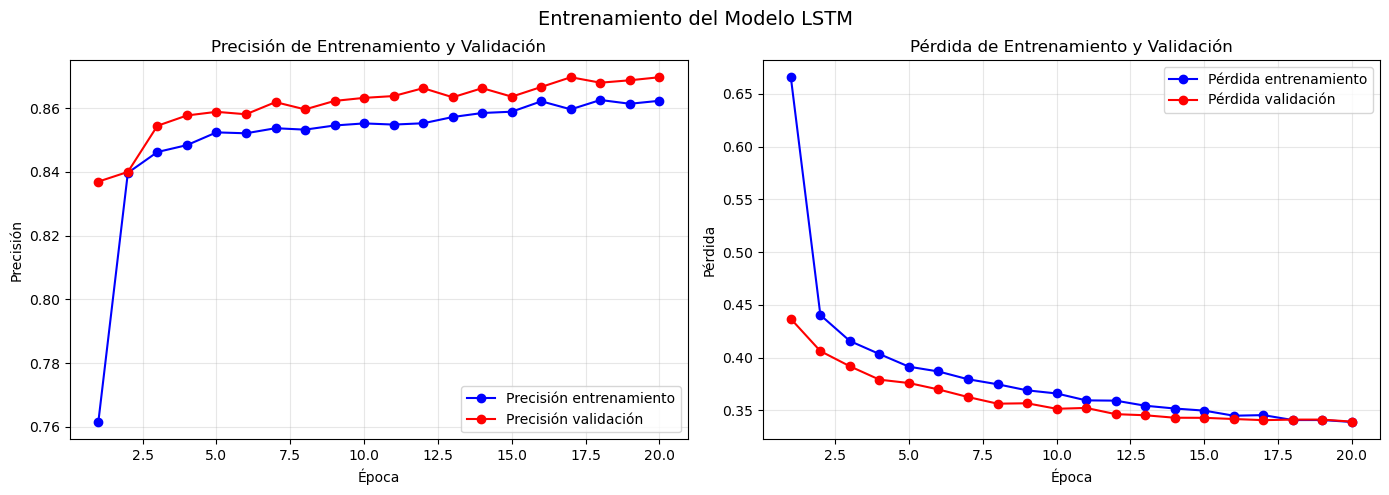

Métricas finales (20 épocas):
  Precisión entrenamiento: 0.8623
  Precisión validación: 0.8697
  Pérdida entrenamiento: 0.3391
  Pérdida validación: 0.3394

Mejor rendimiento (época 17):
  Precisión validación: 0.8697
  Pérdida validación: 0.3408

Brecha de entrenamiento-validación: -0.0074
✓ No hay señales significativas de sobreajuste.


In [52]:
visualizar_entrenamiento_recurrente(
    history_lstm, 
    "Entrenamiento del Modelo LSTM"
)


Evaluando modelo LSTM:
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


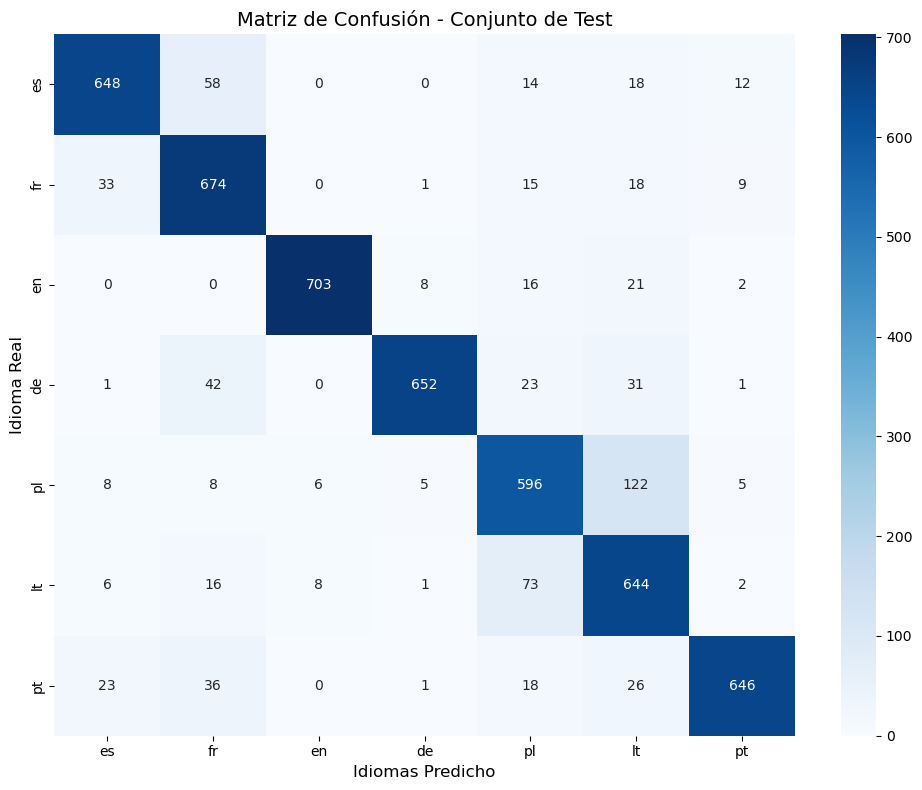

Resultados en conjunto de Test:
Precisión global: 0.8691

Métricas por clase:


,Precision,Recall,F1-Score,Support
es,0.901252,0.864000,0.882233,750.0
fr,0.808153,0.898667,0.851010,750.0
en,0.980474,0.937333,0.958419,750.0
de,0.976048,0.869333,0.919605,750.0
pl,0.789404,0.794667,0.792027,750.0
lt,0.731818,0.858667,0.790184,750.0
pt,0.954210,0.861333,0.905396,750.0


<Figure size 1200x500 with 0 Axes>

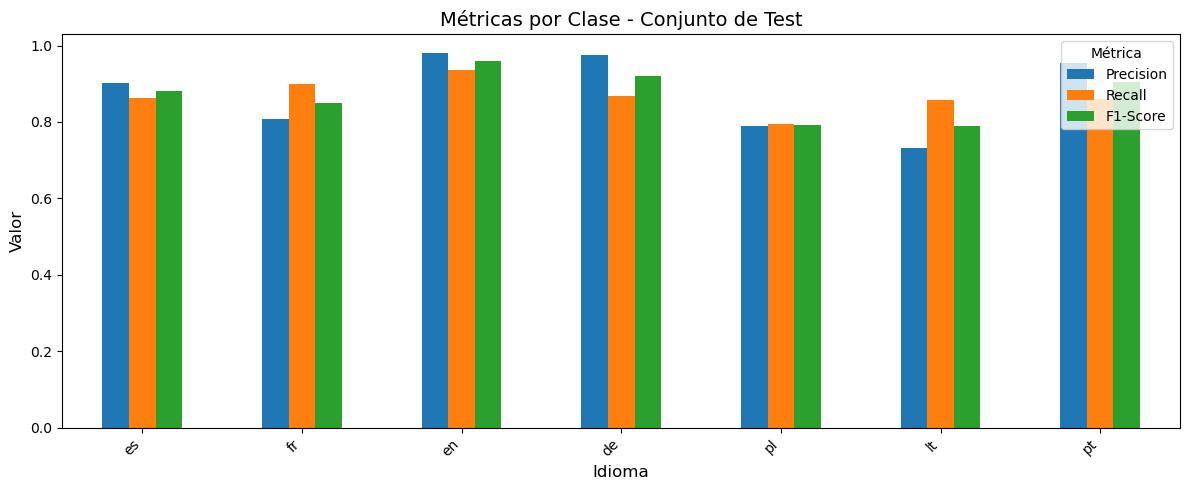


Ejemplos incorrectamente clasificados (687):

Texto original: 'merci beaucoup madame grossetête'
Tokens: '<OOV> <OOV> <OOV> <OOV>'
  - Idioma real: fr
  - Idioma predicha: pl
  - Confianza en predicción: 0.3105
  - Confianza en idioma real: 0.0691

Texto original: 'multiplicación vegetativa de la vid'
Tokens: '<OOV> <OOV> de la <OOV>'
  - Idioma real: es
  - Idioma predicha: fr
  - Confianza en predicción: 0.6005
  - Confianza en idioma real: 0.3972

Texto original: 'συνεδρίαση αρχίζει στις  πμ'
Tokens: '<OOV> <OOV> <OOV> <OOV>'
  - Idioma real: lt
  - Idioma predicha: pl
  - Confianza en predicción: 0.3105
  - Confianza en idioma real: 0.2761

Texto original: 'voy a considerar ésa una intervención interesante'
Tokens: '<OOV> a <OOV> <OOV> <OOV> <OOV> <OOV>'
  - Idioma real: es
  - Idioma predicha: pt
  - Confianza en predicción: 0.6482
  - Confianza en idioma real: 0.1882

Texto original: 'droits de lhomme'
Tokens: '<OOV> de <OOV>'
  - Idioma real: fr
  - Idioma predicha: es
  - Conf

In [55]:
print("\nEvaluando modelo LSTM:")
eval_lstm = evaluar_modelo_recurrente(
    modelo_lstm,
    datos_recurrentes,
    conjunto='Test'
)

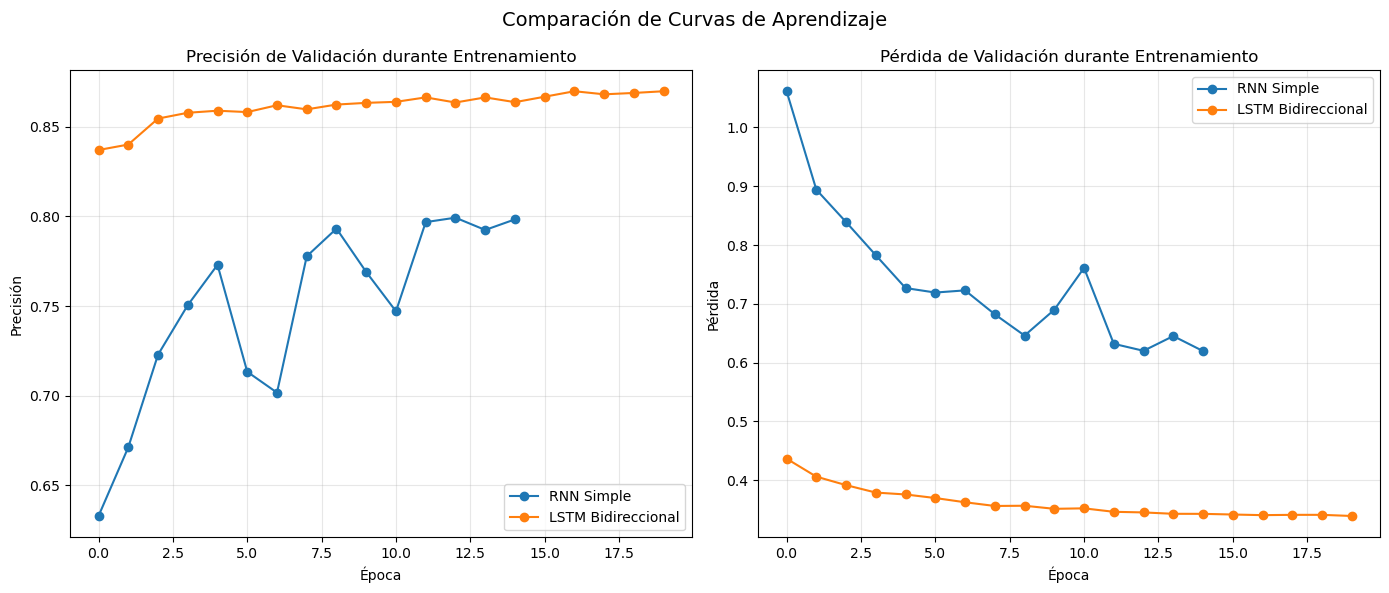


Comparación de Rendimiento:


,RNN Simple,LSTM Bidireccional
Global,0.801333,0.869143
es,0.795165,0.882233
fr,0.743455,0.851010
en,0.935440,0.958419
de,0.845007,0.919605
pl,0.708092,0.792027
lt,0.736447,0.790184
pt,0.866481,0.905396


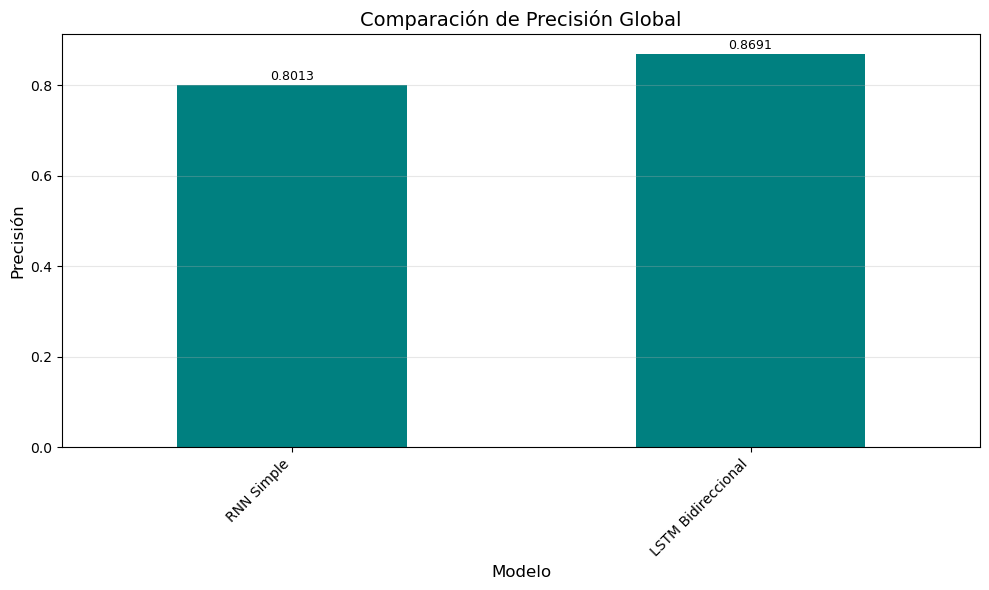

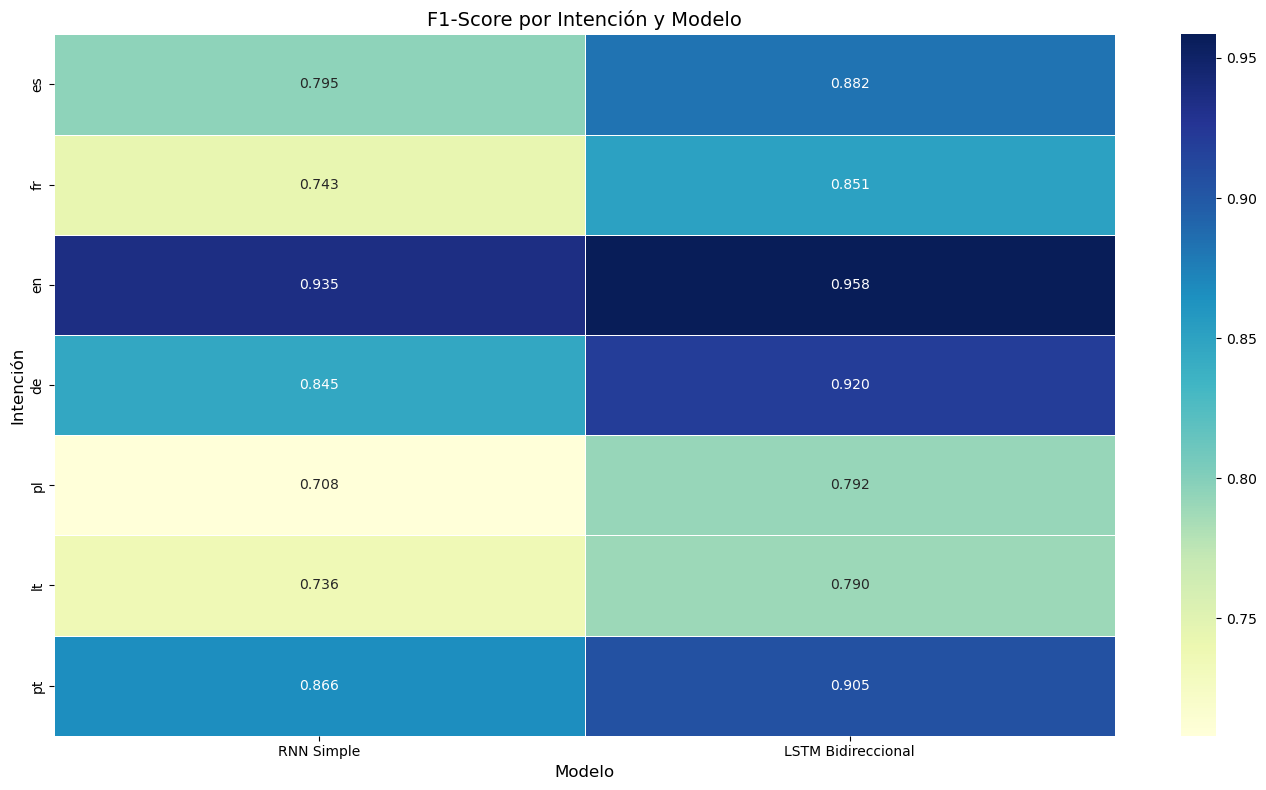


Conclusiones de la comparación:
- El mejor modelo en términos de precisión global es LSTM Bidireccional con 0.8691
- El modelo que converge más rápido es RNN Simple en 15 épocas
- Para el idioma 'es', el mejor modelo es LSTM Bidireccional (F1: 0.8822)
- Para el idioma 'fr', el mejor modelo es LSTM Bidireccional (F1: 0.8510)
- Para el idioma 'en', el mejor modelo es LSTM Bidireccional (F1: 0.9584)
- Para el idioma 'de', el mejor modelo es LSTM Bidireccional (F1: 0.9196)
- Para el idioma 'pl', el mejor modelo es LSTM Bidireccional (F1: 0.7920)
- Para el idioma 'lt', el mejor modelo es LSTM Bidireccional (F1: 0.7902)
- Para el idioma 'pt', el mejor modelo es LSTM Bidireccional (F1: 0.9054)

Ventajas y desventajas:

RNN Simple:
  Fortalezas: Rendimiento destacado en 'en' (0.9354) y 'pt' (0.8665)
  Debilidades: Menor rendimiento en 'pl' (0.7081) y 'lt' (0.7364)

LSTM Bidireccional:
  Fortalezas: Rendimiento destacado en 'en' (0.9584) y 'de' (0.9196)
  Debilidades: Menor rendimiento en 'lt'

In [57]:
def comparar_modelos_recurrentes(historiales, evaluaciones, nombres_modelos):
    """
    Compara diferentes modelos recurrentes.
    
    Args:
        historiales: Lista de historiales de entrenamiento
        evaluaciones: Lista de resultados de evaluación
        nombres_modelos: Lista de nombres de modelos
    """
    # Comparamos curvas de aprendizaje
    plt.figure(figsize=(14, 6))
    
    # Precisión de validación
    plt.subplot(1, 2, 1)
    for i, history in enumerate(historiales):
        plt.plot(history.history['val_accuracy'], marker='o', linestyle='-',
                label=nombres_modelos[i])
    
    plt.title('Precisión de Validación durante Entrenamiento', fontsize=12)
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Precisión', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Pérdida de validación
    plt.subplot(1, 2, 2)
    for i, history in enumerate(historiales):
        plt.plot(history.history['val_loss'], marker='o', linestyle='-',
                label=nombres_modelos[i])
    
    plt.title('Pérdida de Validación durante Entrenamiento', fontsize=12)
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Pérdida', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle('Comparación de Curvas de Aprendizaje', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()
    
    # Comparamos métricas finales
    print("\nComparación de Rendimiento:")
    
    # Creamos DataFrame con métricas de precisión
    metrics_comparison = pd.DataFrame({
        nombres_modelos[i]: [eval['accuracy']] + 
                        [eval['classification_report'][label]['f1-score'] for label in datos_recurrentes['idiomas']]
        for i, eval in enumerate(evaluaciones)
    }, index=['Global'] + datos_recurrentes['idiomas'])
    
    # Mostramos tabla con comparación
    display(metrics_comparison)
    
    # Visualizamos las métricas globales
    plt.figure(figsize=(10, 6))
    metrics_comparison.loc['Global'].plot(kind='bar', color='teal')
    plt.title('Comparación de Precisión Global', fontsize=14)
    plt.ylabel('Precisión', fontsize=12)
    plt.xlabel('Modelo', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Añadimos etiquetas con valores
    for i, v in enumerate(metrics_comparison.loc['Global']):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Comparamos rendimiento por intención
    plt.figure(figsize=(14, 8))
    
    # Heatmap de F1-Score por intención y modelo
    sns.heatmap(metrics_comparison.loc[datos_recurrentes['idiomas']], annot=True, 
              cmap='YlGnBu', fmt='.3f', linewidths=.5)
    plt.title('F1-Score por Intención y Modelo', fontsize=14)
    plt.ylabel('Intención', fontsize=12)
    plt.xlabel('Modelo', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Conclusiones
    print("\nConclusiones de la comparación:")
    
    # Mejor modelo global
    best_model_idx = np.argmax([eval['accuracy'] for eval in evaluaciones])
    best_model = nombres_modelos[best_model_idx]
    print(f"- El mejor modelo en términos de precisión global es {best_model} con {evaluaciones[best_model_idx]['accuracy']:.4f}")
    
    # Comparamos tiempo de convergencia
    epochs_to_converge = [len(history.history['val_loss']) for history in historiales]
    fastest_model_idx = np.argmin(epochs_to_converge)
    print(f"- El modelo que converge más rápido es {nombres_modelos[fastest_model_idx]} en {epochs_to_converge[fastest_model_idx]} épocas")
    
    # Mejor modelo por intención
    for idioma in datos_recurrentes['idiomas']:
        scores = [eval['classification_report'][idioma]['f1-score'] for eval in evaluaciones]
        best_idx = np.argmax(scores)
        print(f"- Para el idioma '{idioma}', el mejor modelo es {nombres_modelos[best_idx]} (F1: {scores[best_idx]:.4f})")
    
    # Ventajas y desventajas
    print("\nVentajas y desventajas:")
    
    for i, model_name in enumerate(nombres_modelos):
        print(f"\n{model_name}:")
        
        # Fortalezas
        good_idiomas = metrics_comparison.loc[datos_recurrentes['idiomas']].iloc[:, i].nlargest(2).index.tolist()
        good_scores = metrics_comparison.loc[good_idiomas, model_name].tolist()
        print(f"  Fortalezas: Rendimiento destacado en '{good_idiomas[0]}' ({good_scores[0]:.4f}) y '{good_idiomas[1]}' ({good_scores[1]:.4f})")
        
        # Debilidades
        poor_idiomas = metrics_comparison.loc[datos_recurrentes['idiomas']].iloc[:, i].nsmallest(2).index.tolist()
        poor_scores = metrics_comparison.loc[poor_idiomas, model_name].tolist()
        print(f"  Debilidades: Menor rendimiento en '{poor_idiomas[0]}' ({poor_scores[0]:.4f}) y '{poor_idiomas[1]}' ({poor_scores[1]:.4f})")

# Comparamos todos los modelos recurrentes
comparar_modelos_recurrentes(
    [history_rnn_simple, history_lstm],
    [eval_rnn_simple, eval_lstm],
    ["RNN Simple", "LSTM Bidireccional"]
)